<h1 style="font-size: 3em;">Etude de marché: Préparation, Nettoyage et Analyse exploratoire des données</h1>

![logo](./logo.jpg)

**Contexte :**
La poule qui chante, consciente des enjeux de la mondialisation et des opportunités offertes par l'internationalisation, souhaite développer son activité à l’échelle internationale. Pour ce faire, une analyse approfondie des sources open data est cruciale afin de cibler les marchés potentiels.

**Objectifs :**

-Sélectionner des indicateurs clés basés sur une analyse PESTEL, qui examinera les facteurs politiques, économiques, sociaux, technologiques, environnementaux et légaux influençant les marchés cibles.

-Segmenter les pays en groupes via des méthodes de clustering et d'analyse en composantes principales (ACP).

-Identifier les marchés les plus favorables pour l'exportation de nos produits.

Dans ce notebook, nous rassemblerons les variables sélectionnées dans un même DataFrame et préparerons nos données pour réaliser, dans un autre notebook, des opérations de réduction (ACP) et de clustering, avant de formuler des analyses et recommandations.

## Sommaire


### [1. Préparation](#section1)
### [2. Analyses exploratoires et prétraitement des fichiers](#section2)
### [3. Agrégation des données](#section3)
### [4. Prétraitement du Df de travail](#section4)
### [5. Analyses univariées et bivariées](#section5)
### [6. Exportations des Data Frame](#section6)

# <a id='section1'></a>1. Préparation 

## Importation des librairies

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats

## Chargement des fichiers

In [2]:
population = pd.read_csv('FAOSTAT_population_2017_2021.csv',delimiter = ';')
pib_politicalstability= pd.read_csv('FAOSTAT_PIB_Political_Stability_2018_2022.csv', delimiter=';')
duty_df= pd.read_csv('TaxeDouanePlusRecente.csv', delimiter=';')
distance = pd.read_csv('DistanceFrance.csv', delimiter=';')
poultry_meat_df= pd.read_csv('DisponibilitéVolailles2012_2022.csv', delimiter=';')
cost_to_export=pd.read_csv('Cost_To_Export.csv',delimiter=';')

# <a id='section2'></a>2. Analyses exploratoires et prétraitement des fichiers

## Fichier population

In [3]:
population.head()

,Country,Element,Year,Population
0,Afghanistan,Total Population - Both sexes,2017,35643418
1,Afghanistan,Urban population,2017,8971472
2,Afghanistan,Total Population - Both sexes,2018,36686784
3,Afghanistan,Urban population,2018,9273302
4,Afghanistan,Total Population - Both sexes,2019,37769499


In [4]:
population.shape

(2305, 4)

In [5]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2305 entries, 0 to 2304
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Country     2305 non-null   object
 1   Element     2305 non-null   object
 2   Year        2305 non-null   int64 
 3   Population  2305 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 72.2+ KB


In [6]:
# Utiliser pivot_table pour réorganiser les données
population = population.pivot_table(index=['Country', 'Year'], 
                           columns='Element', 
                           values='Population', 
                           aggfunc='first').reset_index()

# Renommer les colonnes 
population.columns.name = None 
population.rename(columns={
    'Total Population - Both sexes': 'Total_Population',
    'Urban population': 'Urban_Population'
}, inplace=True)
population

,Country,Year,Total_Population,Urban_Population
0,Afghanistan,2017,35643418.0,8971472.0
1,Afghanistan,2018,36686784.0,9273302.0
2,Afghanistan,2019,37769499.0,9582625.0
3,Afghanistan,2020,38972230.0,9904337.0
4,Afghanistan,2021,40099462.0,10239684.0
...,...,...,...,...
1155,Zimbabwe,2017,14751101.0,5328766.0
1156,Zimbabwe,2018,15052184.0,5447513.0
1157,Zimbabwe,2019,15354608.0,5571525.0
1158,Zimbabwe,2020,15669666.0,5700460.0


In [7]:
population.loc[population['Urban_Population']>population['Total_Population'],'Country'].count()


49

In [8]:
# traiter les inversions entre les colonnes de population urbaine et totale
# Copier le DataFrame original 
df_population_corrected = population

# identifier les incohérences et inverser les valeurs
# condition : Urban_Population > Total_Population
condition = df_population_corrected['Urban_Population'] > df_population_corrected['Total_Population']

# conversion des valeurs
df_population_corrected.loc[condition, ['Total_Population', 'Urban_Population']] = \
    df_population_corrected.loc[condition, ['Urban_Population', 'Total_Population']].values

In [9]:
# calcul de l'évolution démographique sur 5 ans
# Liste pour stocker les résultats avant de les convertir en DataFrame
results = []

# Calculer pour chaque pays la population de la première et de la dernière année, et l'évolution démographique
for country, data in df_population_corrected.groupby('Country'):
    first_year = data['Year'].min()
    last_year = data['Year'].max()
    
    # Population pour la première et la dernière année
    population_totale_first_year = data.loc[data['Year'] == first_year, 'Total_Population'].values[0]
    population_totale_last_year = data.loc[data['Year'] == last_year, 'Total_Population'].values[0]
    
     # Taux de population urbaine pour la dernière année
    urban_population_last_year = data.loc[data['Year'] == last_year, 'Urban_Population'].values[0]
    urban_population_rate_last_year = (urban_population_last_year / population_totale_last_year) * 100 
    
    # Calcul de l'évolution démographique en pourcentage
    population_evolution_rate = ((population_totale_last_year - population_totale_first_year) / population_totale_first_year) * 100
    
    # Ajouter les résultats dans une liste de dictionnaires
    results.append({
        'Country': country,
        'Population': population_totale_last_year,
        'Urban_Population_Rate': round(urban_population_rate_last_year,2),
        'Demographic_Evolution': round(population_evolution_rate, 2)
    })

In [10]:
# Convertir la liste en DataFrame
population_2021 = pd.DataFrame(results)

In [11]:
population_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                232 non-null    object 
 1   Population             231 non-null    float64
 2   Urban_Population_Rate  229 non-null    float64
 3   Demographic_Evolution  231 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.4+ KB


In [12]:
population_2021.isna().mean()

Country                  0.000000
Population               0.004310
Urban_Population_Rate    0.012931
Demographic_Evolution    0.004310
dtype: float64

In [13]:
population_2021.describe()

,Population,Urban_Population_Rate,Demographic_Evolution
count,2.310000e+02,229.000000,231.000000
mean,3.424058e+07,61.483668,4.593074
std,1.385094e+08,24.272889,5.053890
min,8.000000e+02,0.000000,-10.890000
25%,4.246590e+05,42.290000,0.970000
50%,5.457154e+06,63.880000,4.330000
75%,2.183921e+07,81.900000,7.975000
max,1.457935e+09,99.510000,24.430000


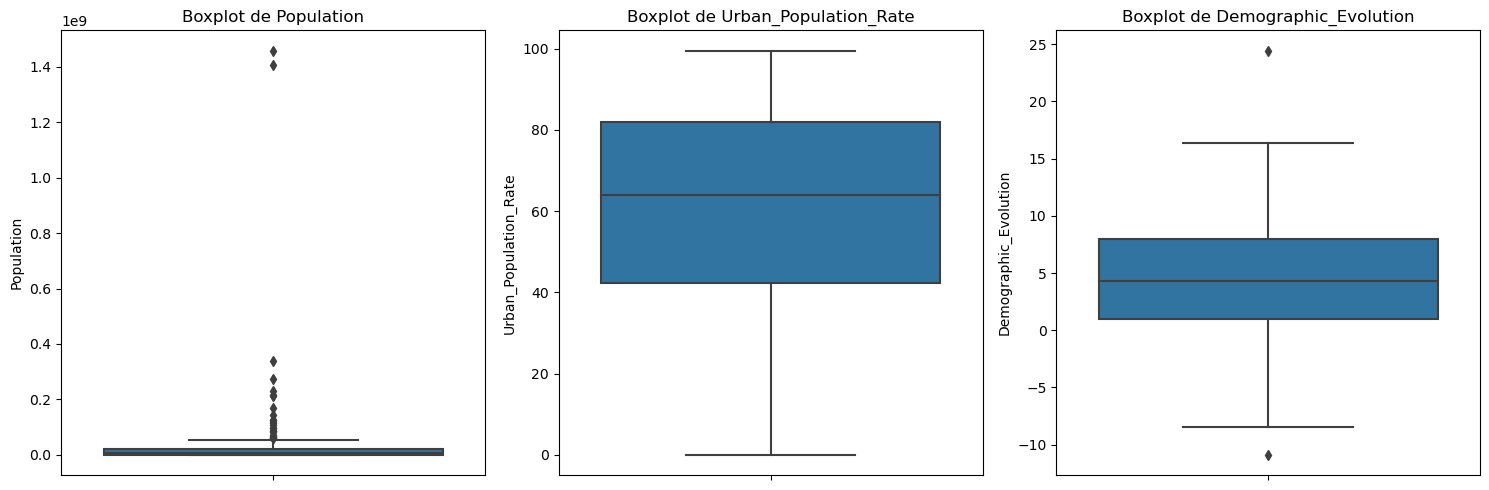

In [14]:
# tracer les boxplots pour identifier les outliers
colonnes = ['Population', 'Urban_Population_Rate', 'Demographic_Evolution'] 

# Initialiser la figure et les subplots
fig, axes = plt.subplots(nrows=1, ncols=len(colonnes), figsize=(15, 5))  

# Boucler sur les colonnes et créer un boxplot pour chacune
for i, col in enumerate(colonnes):
    sns.boxplot(data=population_2021, y=col, ax=axes[i])  
    axes[i].set_title(f"Boxplot de {col}")  

plt.tight_layout()
plt.show()

On constate des outliers notamment sur Population, causés par L'Inde et la Chine

## Fichier pib_politicalstability

In [15]:
pib_politicalstability.head()

,Country,Item,Year,Value
0,Afghanistan,"Gross domestic product per capita, PPP, (const...",2018,2906.80
1,Afghanistan,"Gross domestic product per capita, PPP, (const...",2019,2934.00
2,Afghanistan,"Gross domestic product per capita, PPP, (const...",2020,2776.60
3,Afghanistan,"Gross domestic product per capita, PPP, (const...",2021,2138.90
4,Afghanistan,Political stability and absence of violence/te...,2018,-2.75


In [16]:
pib_politicalstability.shape

(1898, 4)

In [17]:
pib_politicalstability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  1898 non-null   object 
 1   Item     1898 non-null   object 
 2   Year     1898 non-null   int64  
 3   Value    1898 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 59.4+ KB


In [18]:
# Utiliser pivot_table pour réorganiser les données
pib_politicalstability = pib_politicalstability.pivot_table(
    index=['Country', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='first'
).reset_index()

# Vérifier si les colonnes ont un nom d'index et le supprimer
pib_politicalstability.columns.name = None

# Renommer les colonnes
pib_politicalstability.rename(columns={
    'Gross domestic product per capita, PPP, (constant 2017 international $)': 'GDP (ppp)',
    'Political stability and absence of violence/terrorism (index)': 'PoliticalStability'
}, inplace=True)
pib_politicalstability

,Country,Year,GDP (ppp),PoliticalStability
0,Afghanistan,2018,2906.8,-2.75
1,Afghanistan,2019,2934.0,-2.65
2,Afghanistan,2020,2776.6,-2.70
3,Afghanistan,2021,2138.9,-2.52
4,Afghanistan,2022,NaN,-2.55
...,...,...,...,...
970,Zimbabwe,2018,3716.9,-0.72
971,Zimbabwe,2019,3413.0,-0.94
972,Zimbabwe,2020,3082.9,-1.05
973,Zimbabwe,2021,3276.3,-0.95


In [19]:
# Liste pour stocker les résultats avant de les convertir en DataFrame
results = []

# Calculer pour chaque pays le GDP de la première et de la dernière année, et l'évolution sur 5 ans
for country, data in pib_politicalstability.groupby('Country'):
    first_year = data['Year'].min()
    last_year = data['Year'].max()
    
    # Vérifier si le GDP pour la dernière année (last_year) est manquant
    GDP_last_year = data.loc[data['Year'] == last_year, 'GDP (ppp)'].values[0] if not pd.isna(data.loc[data['Year'] == last_year, 'GDP (ppp)']).any() else None
    PoliticalStability_last_year = data.loc[data['Year'] == last_year, 'PoliticalStability'].values[0] if not pd.isna(data.loc[data['Year'] == last_year, 'PoliticalStability']).any() else None

    # Si GDP est manquant, aller chercher la valeur pour l'année précédente (s'il y en a une)
    if GDP_last_year is None or PoliticalStability_last_year is None:
        previous_year = data[data['Year'] < last_year]['Year'].max()
        GDP_last_year = data.loc[data['Year'] == previous_year, 'GDP (ppp)'].values[0]
        PoliticalStability_last_year = data.loc[data['Year'] == previous_year, 'PoliticalStability'].values[0]

    # GDP pour la première année
    GDP_first_year = data.loc[data['Year'] == first_year, 'GDP (ppp)'].values[0]
    
    # Calcul de l'évolution du GDP en pourcentage
    GDP_evolution_rate = ((GDP_last_year - GDP_first_year) / GDP_first_year) * 100
    
    # Ajouter les résultats dans une liste de dictionnaires
    results.append({
        'Country': country,
        'GDP': GDP_last_year,
        'GDP_Evolution': round(GDP_evolution_rate, 2),
        'Political Stability': round(PoliticalStability_last_year, 2)
    })

# Convertir la liste en DataFrame
GDP_Stability = pd.DataFrame(results)


In [20]:
GDP_Stability.head()

,Country,GDP,GDP_Evolution,Political Stability
0,Afghanistan,2138.9,-26.42,-2.52
1,Albania,17261.0,16.33,0.11
2,Algeria,13090.9,-4.50,-0.74
3,American Samoa,NaN,NaN,1.07
4,Andorra,63379.0,0.32,1.59


In [21]:
GDP_Stability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country              195 non-null    object 
 1   GDP                  187 non-null    float64
 2   GDP_Evolution        187 non-null    float64
 3   Political Stability  194 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.2+ KB


In [22]:
GDP_Stability.isna().mean()

Country                0.000000
GDP                    0.041026
GDP_Evolution          0.041026
Political Stability    0.005128
dtype: float64

In [23]:
GDP_Stability.describe()

,GDP,GDP_Evolution,Political Stability
count,187.000000,187.000000,194.000000
mean,25152.278610,3.493583,-0.089330
std,26112.026982,16.609053,0.993552
min,857.200000,-27.600000,-2.660000
25%,5697.950000,-2.530000,-0.647500
50%,15229.500000,3.140000,-0.015000
75%,38347.500000,7.880000,0.720000
max,137059.000000,187.980000,1.880000


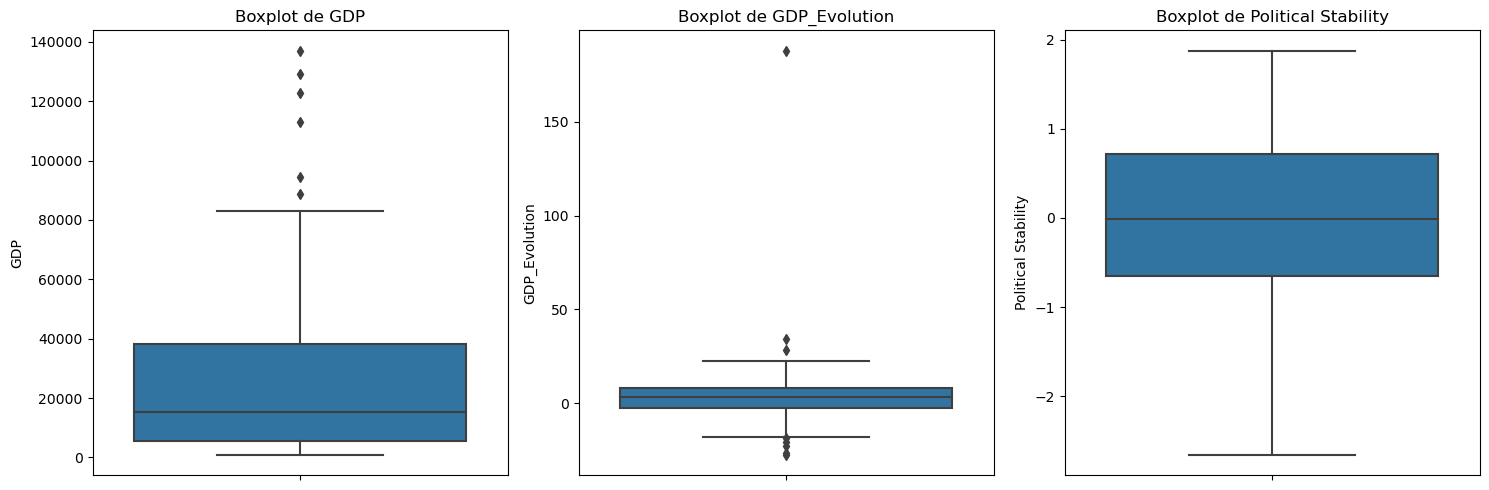

In [24]:
# tracer les boxplots pour identifier les outliers

# Définir les colonnes pour le boxplot
colonnes = ['GDP', 'GDP_Evolution', 'Political Stability']
fig, axes = plt.subplots(1, len(colonnes), figsize=(15, 5))

# Boucler sur les colonnes et créer un boxplot pour chacune
for i, col in enumerate(colonnes):
    sns.boxplot(data=GDP_Stability, y=col, ax=axes[i])  
    axes[i].set_title(f"Boxplot de {col}")  

plt.tight_layout()
plt.show()

In [25]:
# vérification des outliers sur GDP_Evolution
GDP_Stability.loc[GDP_Stability['GDP_Evolution']>50,:]

,Country,GDP,GDP_Evolution,Political Stability
75,Guyana,37667.8,187.98,0.03


In [26]:
# vérification des outliers sur GDP
GDP_Stability.loc[GDP_Stability['GDP']>80000,:]

,Country,GDP,GDP_Evolution,Political Stability
20,Bermuda,94531.3,-0.32,1.03
84,Ireland,122596.0,34.27,0.88
102,Luxembourg,137059.0,3.14,1.06
128,Norway,88712.0,4.02,0.86
141,Qatar,113157.0,5.57,0.96
157,Singapore,129084.0,9.93,1.46
169,Switzerland,83019.8,3.80,1.16


## Fichiers des taxes douanières sur le poulet

In [27]:
duty_df.head()

,Country,AVDuty average,Exchange rate
0,"Macao, Chine",0,"8,063390083"
1,Congo,5,"606,5697502"
2,"Cor?e, R?publique de","21,58333333","1305,6625"
3,Mexique,5,"17,75871667"
4,C?te d'Ivoire,35,"606,5697502"


In [28]:
duty_df['Country'].unique()

array(['Macao, Chine', 'Congo', 'Cor?e, R?publique de', 'Mexique',
       "C?te d'Ivoire", 'Madagascar', 'Mac?doine du Nord', 'Colombie',
       'Tchad', 'Lesotho', 'Taipei chinois', 'Panama', 'Suisse',
       'Singapour', 'Hong Kong, Chine', 'Gabon', 'Canada', 'Chine',
       'Philippines', 'Albanie', 'Argentine', 'Australie',
       'Bahre?n, Royaume de', 'Norv?ge', 'Cameroun', 'Ukraine', 'Japon',
       'Br?sil', 'R?publique centrafricaine', 'Tonga', 'Maldives',
       'R?publique d?mocratique populaire lao', 'Nouvelle-Z?lande',
       'Myanmar', 'Kazakhstan', 'Oman', 'Ouganda', 'Kenya', 'Rwanda',
       'Maurice', 'R?publique dominicaine', 'Guatemala', 'Costa Rica',
       'Angola', "Arabie saoudite, Royaume d'", 'Barbade',
       'Union europ?enne', 'Burundi', 'Cambodge', 'Chili', 'Islande',
       'Cuba', 'P?rou', 'Indon?sie', 'Tha?lande', "?tats-Unis d'Am?rique",
       'Inde', 'Guyana', 'Tanzanie', 'Sainte-Lucie', 'Uruguay', 'Qatar',
       'T?rkiye', 'Trinit?-et-Tobago', 'Seyc

In [29]:
# Dictionnaire de correspondance pour corriger les erreurs d'encodage et traduire les noms de pays en anglais
corrections = {
    'Macao, Chine': 'Macau, China',
    'Congo': 'Congo',
    'Cor?e, R?publique de': 'South Korea',
    'Mexique': 'Mexico',
    "C?te d'Ivoire": 'Ivory Coast',
    'Madagascar': 'Madagascar',
    'Mac?doine du Nord': 'North Macedonia',
    'Colombie': 'Colombia',
    'Tchad': 'Chad',
    'Lesotho': 'Lesotho',
    'Taipei chinois': 'Taiwan',
    'Panama': 'Panama',
    'Suisse': 'Switzerland',
    'Singapour': 'Singapore',
    'Hong Kong, Chine': 'Hong Kong, China',
    'Gabon': 'Gabon',
    'Canada': 'Canada',
    'Chine': 'China',
    'Philippines': 'Philippines',
    'Albanie': 'Albania',
    'Argentine': 'Argentina',
    'Australie': 'Australia',
    'Bahre?n, Royaume de': 'Bahrain',
    'Norv?ge': 'Norway',
    'Cameroun': 'Cameroon',
    'Ukraine': 'Ukraine',
    'Japon': 'Japan',
    'Br?sil': 'Brazil',
    'R?publique centrafricaine': 'Central African Republic',
    'Tonga': 'Tonga',
    'Maldives': 'Maldives',
    'R?publique d?mocratique populaire lao': 'Laos',
    'Nouvelle-Z?lande': 'New Zealand',
    'Myanmar': 'Myanmar',
    'Kazakhstan': 'Kazakhstan',
    'Oman': 'Oman',
    'Ouganda': 'Uganda',
    'Kenya': 'Kenya',
    'Rwanda': 'Rwanda',
    'Maurice': 'Mauritius',
    'R?publique dominicaine': 'Dominican Republic',
    'Guatemala': 'Guatemala',
    'Costa Rica': 'Costa Rica',
    'Angola': 'Angola',
    "Arabie saoudite, Royaume d'": 'Saudi Arabia',
    'Barbade': 'Barbados',
    'Union europ?enne': 'European Union',
    'Burundi': 'Burundi',
    'Cambodge': 'Cambodia',
    'Chili': 'Chile',
    'Islande': 'Iceland',
    'Cuba': 'Cuba',
    'P?rou': 'Peru',
    'Indon?sie': 'Indonesia',
    'Tha?lande': 'Thailand',
    "?tats-Unis d'Am?rique": 'United States of America',
    'Inde': 'India',
    'Guyana': 'Guyana',
    'Tanzanie': 'Tanzania',
    'Sainte-Lucie': 'Saint Lucia',
    'Uruguay': 'Uruguay',
    'Qatar': 'Qatar',
    'T?rkiye': 'Turkey',
    'Trinit?-et-Tobago': 'Trinidad and Tobago',
    'Seychelles': 'Seychelles',
    'S?n?gal': 'Senegal',
    'Royaume-Uni': 'United Kingdom',
    'Samoa': 'Samoa',
    'Togo': 'Togo',
    'Sierra Leone': 'Sierra Leone',
    'Afrique du Sud': 'South Africa',
    'Nig?ria': 'Nigeria',
    'Belize': 'Belize',
    'B?nin': 'Benin',
    'Botswana': 'Botswana',
    'Brun?i Darussalam': 'Brunei Darussalam',
    'Burkina Faso': 'Burkina Faso',
    'Cabo Verde': 'Cape Verde',
    'El Salvador': 'El Salvador',
    'Eswatini': 'Eswatini',
    'F?d?ration de Russie': 'Russia',
    'Gambie': 'Gambia',
    'Ghana': 'Ghana',
    'Paraguay': 'Paraguay',
    'Guin?e': 'Guinea',
    'Isra?l': 'Israel',
    'Lib?ria': 'Liberia',
    'Viet Nam': 'Vietnam',
    'Malaisie': 'Malaysia',
    'Mali': 'Mali',
    'Moldova, R?publique de': 'Moldova',
    'Mongolie': 'Mongolia',
    'Mont?n?gro': 'Montenegro',
    'Namibie': 'Namibia',
    'Nicaragua': 'Nicaragua',
    'Niger': 'Niger',
    'Guin?e-Bissau': 'Guinea-Bissau',
    'Zimbabwe': 'Zimbabwe'
}

# Appliquer les corrections et traductions sur la colonne 'Country' de duty_df
duty_df['Country'] = duty_df['Country'].replace(corrections)


In [30]:
duty_df['Country'].unique()

array(['Macau, China', 'Congo', 'South Korea', 'Mexico', 'Ivory Coast',
       'Madagascar', 'North Macedonia', 'Colombia', 'Chad', 'Lesotho',
       'Taiwan', 'Panama', 'Switzerland', 'Singapore', 'Hong Kong, China',
       'Gabon', 'Canada', 'China', 'Philippines', 'Albania', 'Argentina',
       'Australia', 'Bahrain', 'Norway', 'Cameroon', 'Ukraine', 'Japan',
       'Brazil', 'Central African Republic', 'Tonga', 'Maldives', 'Laos',
       'New Zealand', 'Myanmar', 'Kazakhstan', 'Oman', 'Uganda', 'Kenya',
       'Rwanda', 'Mauritius', 'Dominican Republic', 'Guatemala',
       'Costa Rica', 'Angola', 'Saudi Arabia', 'Barbados',
       'European Union', 'Burundi', 'Cambodia', 'Chile', 'Iceland',
       'Cuba', 'Peru', 'Indonesia', 'Thailand',
       'United States of America', 'India', 'Guyana', 'Tanzania',
       'Saint Lucia', 'Uruguay', 'Qatar', 'Turkey', 'Trinidad and Tobago',
       'Seychelles', 'Senegal', 'United Kingdom', 'Samoa', 'Togo',
       'Sierra Leone', 'South Africa', 

In [31]:
# Liste des pays de l'UE (hors France)
eu_countries = [
    'Germany', 'Austria', 'Belgium', 'Bulgaria', 'Cyprus',
    'Croatia', 'Denmark', 'Estonia', 'Ireland', 'Italy',
    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
    'Poland', 'Portugal', 'Czech Republic', 'Romania', 
    'Slovakia', 'Slovenia', 'Sweden', 'Hungary', 'Greece',
    'Spain'
]

# Créer un DataFrame à partir de la liste des pays de l'UE
eu_df = pd.DataFrame({
    'Country': eu_countries,
    'AVDuty average': 0,
    'Exchange rate': 0
})

# Ajouter ce DataFrame à duty_df
duty_df = pd.concat([duty_df, eu_df], ignore_index=True)

# Supprimer l'entrée "Union européenne"
duty_df = duty_df[duty_df['Country'] != 'European Union']


In [32]:
duty_df.shape

(122, 3)

In [33]:
duty_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 0 to 122
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         122 non-null    object
 1   AVDuty average  113 non-null    object
 2   Exchange rate   114 non-null    object
dtypes: object(3)
memory usage: 3.8+ KB


In [34]:
# Convertir les colonnes en float, en remplaçant les erreurs par NaN
cols_to_convert=['AVDuty average','Exchange rate']
for col in cols_to_convert:
    duty_df[col]= pd.to_numeric(duty_df[col],errors='coerce')

In [35]:
duty_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 0 to 122
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         122 non-null    object 
 1   AVDuty average  96 non-null     float64
 2   Exchange rate   30 non-null     float64
dtypes: float64(2), object(1)
memory usage: 3.8+ KB


In [36]:
duty_df.isnull().mean()

Country           0.000000
AVDuty average    0.213115
Exchange rate     0.754098
dtype: float64

In [37]:
duty_df.describe()

,AVDuty average,Exchange rate
count,96.000000,30.000000
mean,17.208333,0.233333
std,23.105213,0.568321
min,0.000000,0.000000
25%,0.000000,0.000000
50%,5.500000,0.000000
75%,35.000000,0.000000
max,112.000000,2.000000


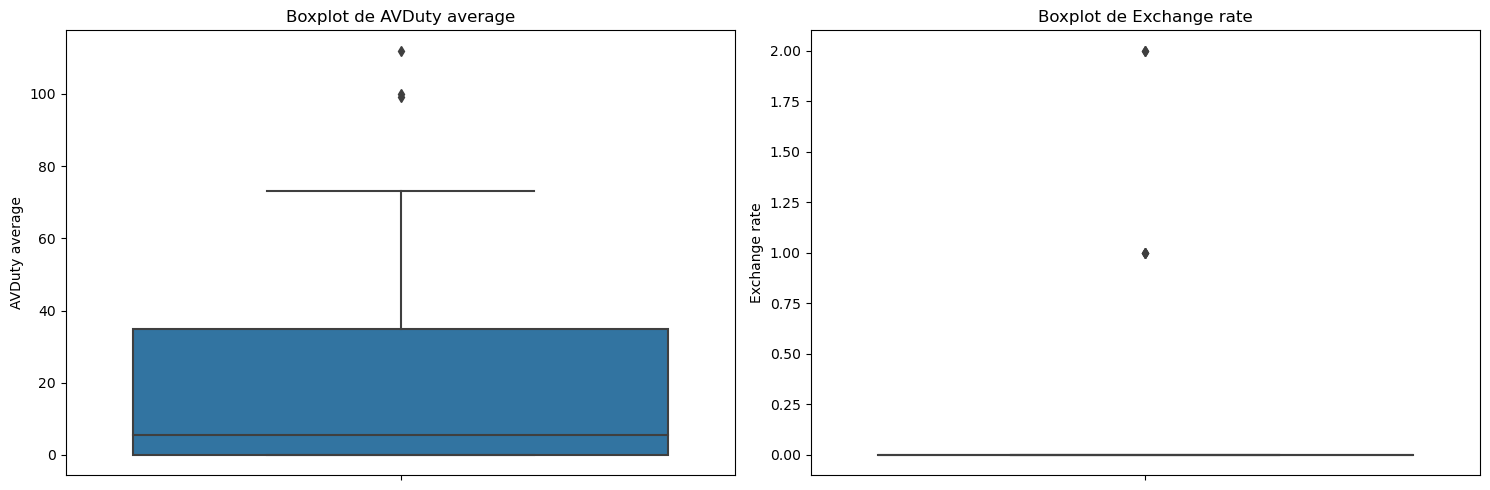

In [38]:
# tracer les boxplots pour identifier les outliers
colonnes = ['AVDuty average', 'Exchange rate'] 

# Initialiser la figure et les subplots
fig, axes = plt.subplots(nrows=1, ncols=len(colonnes), figsize=(15, 5))  

# Boucler sur les colonnes et créer un boxplot pour chacune
for i, col in enumerate(colonnes):
    sns.boxplot(data=duty_df, y=col, ax=axes[i])  
    axes[i].set_title(f"Boxplot de {col}")  

plt.tight_layout()
plt.show()

In [39]:
# vérification des outliers sur AVDuty average
duty_df.loc[duty_df['AVDuty average']>80,:]

,Country,AVDuty average,Exchange rate
40,Dominican Republic,99.0,NaN
45,Barbados,112.0,2.0
56,India,100.0,NaN


In [40]:
# vérification des outliers sur Exchange rate
duty_df.loc[duty_df['Exchange rate']>0.5,:]

,Country,AVDuty average,Exchange rate
11,Panama,NaN,1.0
45,Barbados,112.0,2.0
55,United States of America,NaN,1.0
72,Belize,40.0,2.0
78,El Salvador,73.0,1.0


### Fichier distance

In [41]:
distance.head()

,country,Distance
0,Aruba,7686
1,Afghanistan,5590
2,Angola,6510
3,Anguilla,6711
4,Albania,1604


In [42]:
distance.shape

(225, 2)

In [43]:
distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   country   225 non-null    object
 1   Distance  225 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB


In [44]:
distance.rename(columns={'country':'Country'}, inplace=True)

In [45]:
distance.describe()

,Distance
count,225.000000
mean,6643.133333
std,4275.524596
min,262.000000
25%,3373.000000
50%,6510.000000
75%,8919.000000
max,19264.000000


## Fichier poultry meat 

In [46]:
poultry_meat_df.head()

,Zone,Élément,Année,Unité,Valeur
0,Afghanistan,Production,2012,1000 t,25
1,Afghanistan,Importations - quantité,2012,1000 t,22
2,Afghanistan,Variation de stock,2012,1000 t,-16
3,Afghanistan,Disponibilité intérieure,2012,1000 t,62
4,Afghanistan,Traitement,2012,1000 t,0


In [47]:
# Utiliser pivot_table pour réorganiser les données
poultry_meat_df = poultry_meat_df.pivot_table(index= ['Zone','Année'],
                                             columns = 'Élément',
                                             values= 'Valeur',
                                             aggfunc = 'first').reset_index()

In [48]:
poultry_meat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 10 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   Zone                                                    2023 non-null   object
 1   Année                                                   2023 non-null   int64 
 2   Disponibilité alimentaire en quantité (kg/personne/an)  2023 non-null   object
 3   Disponibilité intérieure                                2023 non-null   object
 4   Exportations - quantité                                 1590 non-null   object
 5   Importations - quantité                                 2020 non-null   object
 6   Nourriture                                              2023 non-null   object
 7   Production                                              1997 non-null   object
 8   Traitement                                      

In [49]:
# conversion du type object en float pour les colonnes 2 à 9
cols_to_convert = [
    'Disponibilité alimentaire en quantité (kg/personne/an)',
    'Disponibilité intérieure',
    'Exportations - quantité',
    'Importations - quantité',
    'Nourriture',
    'Production',
    'Traitement',
    'Variation de stock'
]

# Convertir les colonnes en float, en remplaçant les erreurs par NaN
for col in cols_to_convert:
    poultry_meat_df[col] = pd.to_numeric(poultry_meat_df[col], errors='coerce')

In [50]:
poultry_meat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 10 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Zone                                                    2023 non-null   object 
 1   Année                                                   2023 non-null   int64  
 2   Disponibilité alimentaire en quantité (kg/personne/an)  16 non-null     float64
 3   Disponibilité intérieure                                2023 non-null   int64  
 4   Exportations - quantité                                 1590 non-null   float64
 5   Importations - quantité                                 2020 non-null   float64
 6   Nourriture                                              2023 non-null   int64  
 7   Production                                              1997 non-null   float64
 8   Traitement                            

In [51]:
poultry_meat_df.head()

Élément,Zone,Année,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité intérieure,Exportations - quantité,Importations - quantité,Nourriture,Production,Traitement,Variation de stock
0,Afghanistan,2012,NaN,62,NaN,22.0,62,25.0,0.0,-16.0
1,Afghanistan,2013,NaN,67,NaN,48.0,67,26.0,0.0,8.0
2,Afghanistan,2014,NaN,69,0.0,43.0,69,25.0,NaN,-1.0
3,Afghanistan,2015,NaN,66,0.0,43.0,66,25.0,NaN,1.0
4,Afghanistan,2016,2.0,69,NaN,37.0,69,24.0,NaN,-8.0


In [52]:
# abandonner les colonnes inutiles
poultry_meat_df= poultry_meat_df.drop(['Disponibilité alimentaire en quantité (kg/personne/an)','Disponibilité intérieure','Exportations - quantité','Production','Traitement','Variation de stock'], axis=1)

In [53]:
# renommer les colonnes
poultry_meat_df.rename(columns= {'Zone':'Country', 'Année':'Year','Importations - quantité':'Importations', 'Nourriture':'Consumption'}, inplace=True)

In [54]:
# Filtrer le DataFrame pour ne garder que les années 2017 à 2021
poultry_meat_df = poultry_meat_df.loc[poultry_meat_df['Year'].isin([2017,2018, 2019, 2020, 2021])]
poultry_meat_df

Élément,Country,Year,Importations,Consumption
5,Afghanistan,2017,29.0,64
6,Afghanistan,2018,25.0,53
7,Afghanistan,2019,44.0,69
8,Afghanistan,2020,36.0,64
9,Afghanistan,2021,33.0,61
...,...,...,...,...
2017,Îles Salomon,2017,5.0,5
2018,Îles Salomon,2018,5.0,5
2019,Îles Salomon,2019,4.0,5
2020,Îles Salomon,2020,5.0,5


In [55]:
# traduction en anglais des noms de pays
country_translation_dict= {
    'Afghanistan': 'Afghanistan',
    'Afrique du Sud': 'South Africa',
    'Albanie': 'Albania',
    'Algérie': 'Algeria',
    'Allemagne': 'Germany',
    'Angola': 'Angola',
    'Antigua-et-Barbuda': 'Antigua and Barbuda',
    'Arabie saoudite': 'Saudi Arabia',
    'Argentine': 'Argentina',
    'Arménie': 'Armenia',
    'Australie': 'Australia',
    'Autriche': 'Austria',
    'Azerbaïdjan': 'Azerbaijan',
    'Bahamas': 'Bahamas',
    'Bahreïn': 'Bahrain',
    'Bangladesh': 'Bangladesh',
    'Barbade': 'Barbados',
    'Belgique': 'Belgium',
    'Belize': 'Belize',
    'Bhoutan': 'Bhutan',
    'Bolivie (État plurinational de)': 'Bolivia (Plurinational State of)',
    'Bosnie-Herzégovine': 'Bosnia and Herzegovina',
    'Botswana': 'Botswana',
    'Brésil': 'Brazil',
    'Bulgarie': 'Bulgaria',
    'Burkina Faso': 'Burkina Faso',
    'Burundi': 'Burundi',
    'Bélarus': 'Belarus',
    'Bénin': 'Benin',
    'Cabo Verde': 'Cabo Verde',
    'Cambodge': 'Cambodia',
    'Cameroun': 'Cameroon',
    'Canada': 'Canada',
    'Chili': 'Chile',
    'Chine': 'China',
    'Chine - RAS de Hong-Kong': 'China, Hong Kong SAR',
    'Chine - RAS de Macao': 'China, Macao SAR',
    'Chine, Taiwan Province de': 'Taiwan, Province of China',
    'Chine, continentale': 'China, mainland',
    'Chypre': 'Cyprus',
    'Colombie': 'Colombia',
    'Comores': 'Comoros',
    'Congo': 'Congo',
    'Costa Rica': 'Costa Rica',
    'Croatie': 'Croatia',
    'Cuba': 'Cuba',
    "Côte d'Ivoire": "Côte d'Ivoire",
    'Danemark': 'Denmark',
    'Djibouti': 'Djibouti',
    'Dominique': 'Dominica',
    'El Salvador': 'El Salvador',
    'Espagne': 'Spain',
    'Estonie': 'Estonia',
    'Eswatini': 'Eswatini',
    'Fidji': 'Fiji',
    'Finlande': 'Finland',
    'France': 'France',
    'Fédération de Russie': 'Russian Federation',
    'Gabon': 'Gabon',
    'Gambie': 'Gambia',
    'Ghana': 'Ghana',
    'Grenade': 'Grenada',
    'Grèce': 'Greece',
    'Guatemala': 'Guatemala',
    'Guinée': 'Guinea',
    'Guinée-Bissau': 'Guinea-Bissau',
    'Guyana': 'Guyana',
    'Géorgie': 'Georgia',
    'Haïti': 'Haiti',
    'Honduras': 'Honduras',
    'Hongrie': 'Hungary',
    'Inde': 'India',
    'Indonésie': 'Indonesia',
    "Iran (République islamique d')": 'Iran (Islamic Republic of)',
    'Iraq': 'Iraq',
    'Irlande': 'Ireland',
    'Islande': 'Iceland',
    'Israël': 'Israel',
    'Italie': 'Italy',
    'Jamaïque': 'Jamaica',
    'Japon': 'Japan',
    'Jordanie': 'Jordan',
    'Kazakhstan': 'Kazakhstan',
    'Kenya': 'Kenya',
    'Kirghizistan': 'Kyrgyzstan',
    'Kiribati': 'Kiribati',
    'Koweït': 'Kuwait',
    'Lesotho': 'Lesotho',
    'Lettonie': 'Latvia',
    'Liban': 'Lebanon',
    'Libye': 'Libya',
    'Libéria': 'Liberia',
    'Lituanie': 'Lithuania',
    'Luxembourg': 'Luxembourg',
    'Macédoine du Nord': 'North Macedonia',
    'Madagascar': 'Madagascar',
    'Malaisie': 'Malaysia',
    'Malawi': 'Malawi',
    'Maldives': 'Maldives',
    'Mali': 'Mali',
    'Malte': 'Malta',
    'Maroc': 'Morocco',
    'Maurice': 'Mauritius',
    'Mauritanie': 'Mauritania',
    'Mexique': 'Mexico',
    'Micronésie (États fédérés de)': 'Micronesia (Federated States of)',
    'Mongolie': 'Mongolia',
    'Monténégro': 'Montenegro',
    'Mozambique': 'Mozambique',
    'Myanmar': 'Myanmar',
    'Namibie': 'Namibia',
    'Nauru': 'Nauru',
    'Nicaragua': 'Nicaragua',
    'Niger': 'Niger',
    'Nigéria': 'Nigeria',
    'Norvège': 'Norway',
    'Nouvelle-Calédonie': 'New Caledonia',
    'Nouvelle-Zélande': 'New Zealand',
    'Népal': 'Nepal',
    'Oman': 'Oman',
    'Ouganda': 'Uganda',
    'Ouzbékistan': 'Uzbekistan',
    'Pakistan': 'Pakistan',
    'Panama': 'Panama',
    'Papouasie-Nouvelle-Guinée': 'Papua New Guinea',
    'Paraguay': 'Paraguay',
    'Pays-Bas (Royaume des)': 'Netherlands (Kingdom of the)',
    'Philippines': 'Philippines',
    'Pologne': 'Poland',
    'Polynésie française': 'French Polynesia',
    'Portugal': 'Portugal',
    'Pérou': 'Peru',
    'Qatar': 'Qatar',
    'Roumanie': 'Romania',
    "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord": 'United Kingdom of Great Britain and Northern Ireland',
    'Rwanda': 'Rwanda',
    'République arabe syrienne': 'Syrian Arab Republic',
    'République centrafricaine': 'Central African Republic',
    'République de Corée': 'Republic of Korea',
    'République de Moldova': 'Republic of Moldova',
    'République dominicaine': 'Dominican Republic',
    'République démocratique du Congo': 'Democratic Republic of the Congo',
    'République démocratique populaire lao': 'Lao People\'s Democratic Republic',
    'République populaire démocratique de Corée': 'Democratic People’s Republic of Korea',
    'République-Unie de Tanzanie': 'United Republic of Tanzania',
    'Saint-Kitts-et-Nevis': 'Saint Kitts and Nevis',
    'Saint-Vincent-et-les Grenadines': 'Saint Vincent and the Grenadines',
    'Sainte-Lucie': 'Saint Lucia',
    'Samoa': 'Samoa',
    'Sao Tomé-et-Principe': 'Sao Tome and Principe',
    'Serbie': 'Serbia',
    'Seychelles': 'Seychelles',
    'Sierra Leone': 'Sierra Leone',
    'Slovaquie': 'Slovakia',
    'Slovénie': 'Slovenia',
    'Somalie': 'Somalia',
    'Soudan': 'Sudan',
    'Soudan du Sud': 'South Sudan',
    'Sri Lanka': 'Sri Lanka',
    'Suisse': 'Switzerland',
    'Suriname': 'Suriname',
    'Suède': 'Sweden',
    'Sénégal': 'Senegal',
    'Tadjikistan': 'Tajikistan',
    'Tchad': 'Chad',
    'Tchéquie': 'Czechia',
    'Thaïlande': 'Thailand',
    'Timor-Leste': 'Timor-Leste',
    'Togo': 'Togo',
    'Tonga': 'Tonga',
    'Trinité-et-Tobago': 'Trinidad and Tobago',
    'Tunisie': 'Tunisia',
    'Turkménistan': 'Turkmenistan',
    'Turquie': 'Türkiye',
    'Tuvalu': 'Tuvalu',
    'Ukraine': 'Ukraine',
    'Uruguay': 'Uruguay',
    'Vanuatu': 'Vanuatu',
    'Venezuela (République bolivarienne du)': 'Venezuela (Bolivarian Republic of)',
    'Viet Nam': 'Viet Nam',
    'Yémen': 'Yemen',
    'Zambie': 'Zambia',
    'Zimbabwe': 'Zimbabwe',
    'Égypte': 'Egypt',
    'Émirats arabes unis': 'United Arab Emirates',
    'Équateur': 'Ecuador',
    'Érythrée': 'Eritrea',
    'États-Unis d\'Amérique': 'United States of America',
    'Éthiopie': 'Ethiopia'
}
poultry_meat_df['Country'] = poultry_meat_df['Country'].replace(country_translation_dict)
poultry_meat_df['Country'].nunique()

190

In [56]:
# ajout des populations à poultry_meat_df pour faire des calculs
# Suppression de la colonne Urban_Population dans le DataFrame population
population_filtered = population.drop(columns=['Urban_Population'])

# Effectuer la jointure sans la colonne Urban_Population
poultry_meat_population = pd.merge(population_filtered, poultry_meat_df, on=['Country', 'Year'], how='right')


In [57]:
results = []

# Itérer à travers chaque groupe de pays
for country, country_data in poultry_meat_population.groupby('Country'):
    # Vérifier s'il y a des données pour le pays
    if not country_data.empty:
        # Vérifier s'il y a des données pour 2021
        if (country_data['Year'] == 2021).any():
            population2021 = country_data[country_data['Year'] == 2021]['Total_Population'].values[0]
            consumption_2021 = country_data[country_data['Year'] == 2021]['Consumption'].values[0]  
            consumption_per_person_2021 = consumption_2021 * 1000000 / population2021  # kg/personne

            # Priorité à 2017, sinon utiliser 2018
            if (country_data['Year'] == 2017).any():
                year_ref = 2017
            elif (country_data['Year'] == 2018).any():
                year_ref = 2018
            else:
                print(f"Aucune donnée pour 2017 ou 2018 pour le pays {country}.")
                continue

            # Extraire les données pour l'année de référence (2017 ou 2018)
            population_ref = country_data[country_data['Year'] == year_ref]['Total_Population'].values[0]
            consumption_ref = country_data[country_data['Year'] == year_ref]['Consumption'].values[0]   
            consumption_per_person_ref = consumption_ref * 1000000 / population_ref  # kg/personne

            # Calculer l'évolution de la consommation par personne entre l'année de référence et 2021
            if consumption_per_person_ref > 0:  # Éviter la division par zéro
                evolution_consumption_per_person = ((consumption_per_person_2021 - consumption_per_person_ref) / consumption_per_person_ref) 

                # Extraire les importations pour 2021
                importations_2021 = country_data[country_data['Year'] == 2021]['Importations'].values[0]  # en kg

                # Extraire les importations pour l'année de référence (2017 ou 2018)
                importations_ref = country_data[country_data['Year'] == year_ref]['Importations'].values[0]  # en kg

                # Calculer la part des importations par rapport à la consommation pour 2021
                part_importation_consumption_2021 = (importations_2021 / consumption_2021) if consumption_2021 > 0 else 0

                # Calculer la part des importations par rapport à la consommation pour l'année de référence
                part_importation_consumption_ref = (importations_ref / consumption_ref) if consumption_ref > 0 else 0

                # Calculer l'évolution des importations entre l'année de référence et 2021
                if importations_2021 == 0:
                    evolution_importations = 0  # Si les importations en 2021 sont 0, l'évolution est 0
                elif importations_ref != 0:  # Si les importations de référence sont non nulles
                    evolution_importations = ((importations_2021 - importations_ref) / importations_ref) * 100  # En %
                else:
                    evolution_importations = 0  # Si les importations de référence étaient 0, on met l'évolution à 0

                # Calculer l'évolution de la part d'importation entre l'année de référence et 2021
                if part_importation_consumption_ref > 0:
                    evolution_part_importation_consumption = ((part_importation_consumption_2021 - part_importation_consumption_ref) / part_importation_consumption_ref) * 100
                else:
                    evolution_part_importation_consumption = 0

                # Créer un dictionnaire pour stocker les résultats du pays
                country_results = {
                    'Country': country,
                    'Consumption_per_Person': round(consumption_per_person_2021, 2),
                    'Evolution_Consumption_per_Person': round(evolution_consumption_per_person, 2),
                    'Importations': round(importations_2021, 2),
                    'Part_Importation_Consumption': round(part_importation_consumption_2021, 2),
                    'Evolution_Importations': round(evolution_importations, 2),
                    'Evolution_Part_Importation_Consumption': round(evolution_part_importation_consumption, 2)
                }

                # Ajouter les résultats à la liste
                results.append(country_results)
            else:
                print(f"Consommation par personne en {year_ref} est 0 pour le pays {country}.")
        else:
            print(f"Aucune donnée pour 2021 pour le pays {country}.")

# Convertir la liste de résultats en DataFrame
poultry_meat_stats = pd.DataFrame(results)


Aucune donnée pour 2017 ou 2018 pour le pays Bahrain.
Aucune donnée pour 2017 ou 2018 pour le pays Bhutan.
Consommation par personne en 2017 est 0 pour le pays China, Hong Kong SAR.
Consommation par personne en 2017 est 0 pour le pays China, Macao SAR.
Consommation par personne en 2017 est 0 pour le pays China, mainland.
Aucune donnée pour 2021 pour le pays Democratic People’s Republic of Korea.
Aucune donnée pour 2017 ou 2018 pour le pays Micronesia (Federated States of).
Aucune donnée pour 2017 ou 2018 pour le pays Nauru.
Aucune donnée pour 2017 ou 2018 pour le pays Qatar.
Aucune donnée pour 2017 ou 2018 pour le pays South Sudan.
Consommation par personne en 2017 est 0 pour le pays Taiwan, Province of China.
Aucune donnée pour 2017 ou 2018 pour le pays Tonga.
Aucune donnée pour 2017 ou 2018 pour le pays Tuvalu.
Aucune donnée pour 2017 ou 2018 pour le pays Îles Marshall.
Consommation par personne en 2017 est 0 pour le pays Îles Salomon.


In [58]:

poultry_meat_stats

,Country,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption
0,Afghanistan,1.52,-0.15,33.0,0.54,13.79,19.39
1,Albania,12.96,0.13,22.0,0.59,10.00,-1.89
2,Algeria,6.16,-0.11,0.0,0.00,0.00,-100.00
3,Angola,8.72,-0.17,246.0,0.82,-11.19,-6.18
4,Antigua and Barbuda,64.36,-0.02,6.0,1.00,-14.29,-14.29
...,...,...,...,...,...,...,...
170,Venezuela (Bolivarian Republic of),15.25,-0.04,17.0,0.04,-26.09,-20.53
171,Viet Nam,16.94,0.72,211.0,0.13,240.32,91.29
172,Yemen,10.52,0.25,148.0,0.43,80.49,31.59
173,Zambia,3.18,-0.08,20.0,0.32,66.67,61.29


In [59]:
poultry_meat_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 175 non-null    object 
 1   Consumption_per_Person                  175 non-null    float64
 2   Evolution_Consumption_per_Person        175 non-null    float64
 3   Importations                            175 non-null    float64
 4   Part_Importation_Consumption            175 non-null    float64
 5   Evolution_Importations                  175 non-null    float64
 6   Evolution_Part_Importation_Consumption  175 non-null    float64
dtypes: float64(6), object(1)
memory usage: 9.7+ KB


In [60]:
poultry_meat_stats.isna().mean()

Country                                   0.0
Consumption_per_Person                    0.0
Evolution_Consumption_per_Person          0.0
Importations                              0.0
Part_Importation_Consumption              0.0
Evolution_Importations                    0.0
Evolution_Part_Importation_Consumption    0.0
dtype: float64

In [61]:
poultry_meat_stats.describe()

,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,22.552457,0.171029,100.148571,0.443543,48.323200,24.885429
std,18.176294,0.445004,239.919457,0.487772,196.948244,177.163078
min,0.400000,-0.780000,0.000000,0.000000,-92.110000,-100.000000
25%,7.685000,-0.050000,4.000000,0.060000,0.000000,-12.975000
50%,19.130000,0.070000,21.000000,0.280000,3.540000,0.000000
75%,30.925000,0.250000,89.500000,0.775000,34.895000,13.785000
max,86.260000,2.670000,2075.000000,3.690000,1866.670000,1828.780000


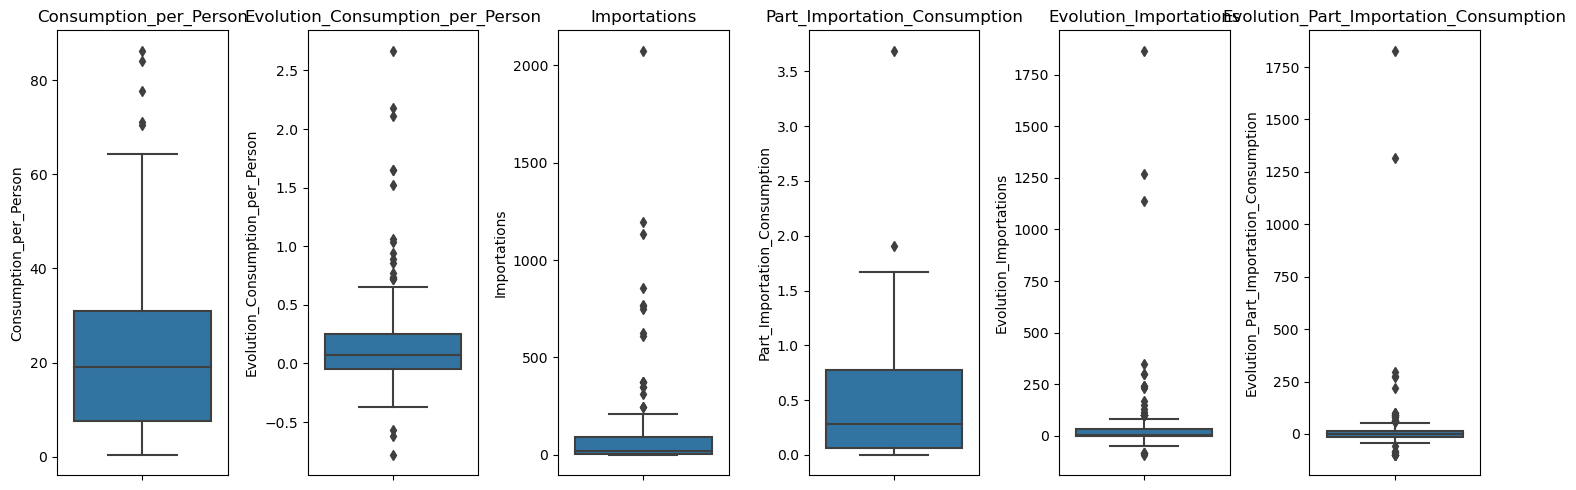

In [62]:
# tracer les boxplots pour identifier les outliers
colonnes = poultry_meat_stats.columns[1:].to_list()

# Initialiser la figure et les subplots
fig, axes = plt.subplots(nrows=1, ncols=len(colonnes), figsize=(15, 5))  

# Boucler sur les colonnes et créer un boxplot pour chacune
for i, col in enumerate(colonnes):
    sns.boxplot(data=poultry_meat_stats, y=col, ax=axes[i])  
    axes[i].set_title(f"{col}")  

plt.tight_layout()
plt.show()

In [63]:
# Fonction pour détecter les outliers en utilisant l'IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Liste pour stocker les outliers
outlier_dfs = []

# Vérifier chaque colonne numérique pour les outliers
for col in colonnes:
    outliers = find_outliers_iqr(poultry_meat_stats, col)
    if not outliers.empty:
        outlier_dfs.append(outliers)

# Concaténer tous les DataFrames d'outliers en un seul DataFrame
outliers_combined = pd.concat(outlier_dfs).drop_duplicates().reset_index(drop=True)

# Afficher le DataFrame des outliers
outliers_combined

,Country,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption
0,Bahamas,71.09,0.42,25.0,0.86,-3.85,-33.69
1,Israel,70.45,-0.06,0.0,0.00,0.00,0.00
2,Saint Kitts and Nevis,84.02,0.34,4.0,1.00,0.00,-25.00
3,Saint Vincent and the Grenadines,86.26,0.14,8.0,0.89,-11.11,-20.99
4,Samoa,77.71,0.08,21.0,1.24,23.53,9.00
...,...,...,...,...,...,...,...
57,Nigeria,1.61,0.14,0.0,0.00,0.00,-100.00
58,Pakistan,7.81,0.32,0.0,0.00,0.00,-100.00
59,Serbia,10.69,-0.11,19.0,0.24,58.33,82.69
60,Zambia,3.18,-0.08,20.0,0.32,66.67,61.29


## Fichier cost_to_export

In [64]:
cost_to_export.head()

,Country,Series Name,Values
0,Afghanistan,Trading across borders: Cost to export: Border...,"452,7778"
1,Afghanistan,Trading across borders: Cost to export: Docume...,"344,4444"
2,Albania,Trading across borders: Cost to export: Border...,"54,67"
3,Albania,Trading across borders: Cost to export: Docume...,10
4,Algeria,Trading across borders: Cost to export: Border...,"592,8889"


In [65]:
cost_to_export.describe()

,Country,Series Name,Values
count,382,382,376
unique,191,2,245
top,Afghanistan,Trading across borders: Cost to export: Border...,0
freq,2,191,39


In [66]:

# Utiliser pivot_table pour réorganiser les données
cost_to_export = cost_to_export.pivot_table(index=['Country'], 
                           columns='Series Name', 
                           values='Values', 
                           aggfunc='first').reset_index()

# Renommer les colonnes 

cost_to_export.rename(columns={
    'Trading across borders: Cost to export: Border compliance (USD) (DB16-20 methodology)': 'Border_Compliance',
    'Trading across borders: Cost to export: Documentary compliance (USD) (DB16-20 methodology)': 'Documentary_Compliance'
}, inplace=True)
cost_to_export

Series Name,Country,Border_Compliance,Documentary_Compliance
0,Afghanistan,"452,7778","344,4444"
1,Albania,"54,67",10
2,Algeria,"592,8889","374,4444"
3,Angola,825,240
4,Antigua and Barbuda,"546,3889","120,8333"
...,...,...,...
183,Vanuatu,709,190
184,Vietnam,290,"139,2308"
185,West Bank and Gaza,"51,11111",80
186,Zambia,370,200


In [67]:
cost_to_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Country                 188 non-null    object
 1   Border_Compliance       188 non-null    object
 2   Documentary_Compliance  188 non-null    object
dtypes: object(3)
memory usage: 4.5+ KB


In [68]:
# Convertir les colonnes en float, en remplaçant les erreurs par NaN
cols_to_convert = ['Border_Compliance','Documentary_Compliance']
for col in cols_to_convert:
    cost_to_export[col] = pd.to_numeric(cost_to_export[col], errors='coerce')

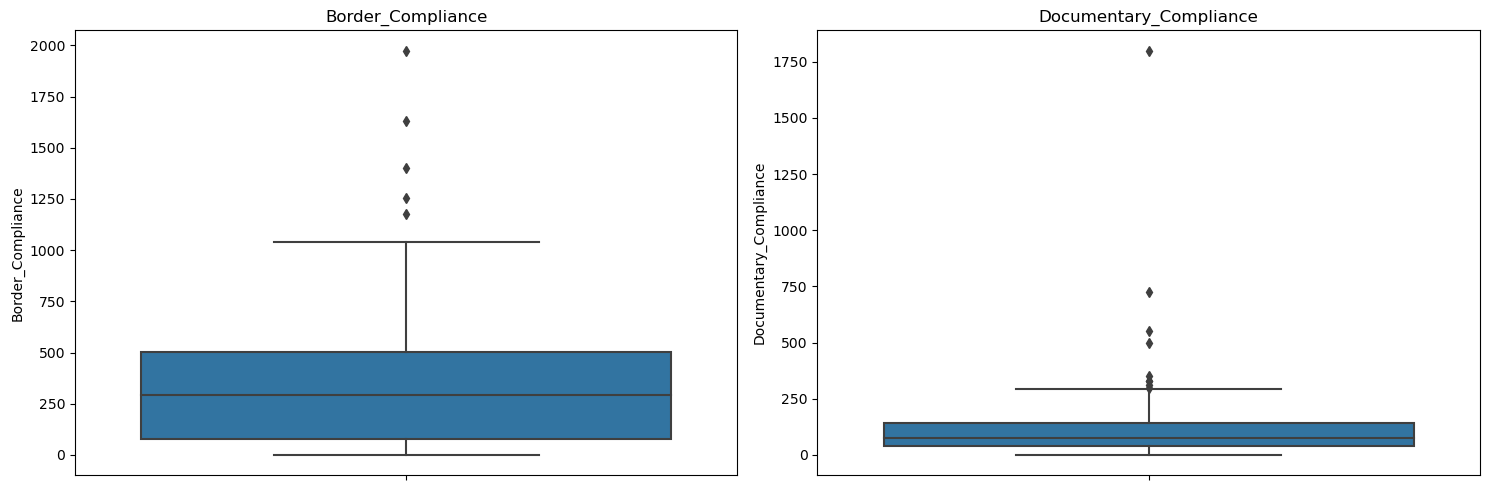

In [69]:
# tracer les boxplots pour identifier les outliers
colonnes = cost_to_export.columns[1:].to_list()

# Initialiser la figure et les subplots
fig, axes = plt.subplots(nrows=1, ncols=len(colonnes), figsize=(15, 5))  

# Boucler sur les colonnes et créer un boxplot pour chacune
for i, col in enumerate(colonnes):
    sns.boxplot(data=cost_to_export, y=col, ax=axes[i])  
    axes[i].set_title(f"{col}")  

plt.tight_layout()
plt.show()

In [70]:
# identification des ouliers
cost_to_export.loc[cost_to_export['Border_Compliance']>1000,:]


Series Name,Country,Border_Compliance,Documentary_Compliance
38,"Congo, Rep.",1975.0,165.0
58,Gabon,1633.0,200.0
141,Samoa,1400.0,180.0
153,South Africa,1257.0,55.0
168,Tanzania,1175.0,275.0
181,Uruguay,1038.0,231.0


In [71]:
cost_to_export.loc[cost_to_export['Documentary_Compliance']>1000,:]


Series Name,Country,Border_Compliance,Documentary_Compliance
77,Iraq,NaN,1800.0


In [72]:
cost_to_export_transformed=cost_to_export.copy()

# <a id='section3'></a>3. Agrégation des données

## Fusion de tous les Data Frames en un seul

In [73]:
# Liste des DataFrames à fusionner
dfs = [population_2021,poultry_meat_stats,distance, duty_df, GDP_Stability,cost_to_export]

# Fusionner tous les DataFrames dans la liste sur 'Country'
merged_df = reduce(lambda left, right: left.merge(right, on='Country', how='left'), dfs)

merged_df


,Country,Population,Urban_Population_Rate,Demographic_Evolution,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption,Distance,AVDuty average,Exchange rate,GDP,GDP_Evolution,Political Stability,Border_Compliance,Documentary_Compliance
0,Afghanistan,40099462.0,25.54,12.50,1.52,-0.15,33.0,0.54,13.79,19.39,5590.0,NaN,NaN,2138.9,-26.42,-2.52,NaN,NaN
1,Albania,2854710.0,64.96,-0.86,12.96,0.13,22.0,0.59,10.00,-1.89,1604.0,10.0,NaN,17261.0,16.33,0.11,NaN,10.0
2,Algeria,44177969.0,73.91,7.39,6.16,-0.11,0.0,0.00,0.00,-100.00,1340.0,NaN,NaN,13090.9,-4.50,-0.74,NaN,NaN
3,American Samoa,48727.0,92.42,-1.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.07,NaN,NaN
4,Andorra,79034.0,85.90,7.04,NaN,NaN,NaN,NaN,NaN,NaN,712.0,NaN,NaN,63379.0,0.32,1.59,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,Wallis and Futuna Islands,11627.0,0.00,-2.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,Western Sahara,565581.0,94.02,9.00,NaN,NaN,NaN,NaN,NaN,NaN,2760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,Yemen,32981641.0,36.13,9.81,10.52,0.25,148.0,0.43,80.49,31.59,5317.0,NaN,NaN,NaN,NaN,-2.58,NaN,NaN
231,Zambia,19473125.0,44.64,12.57,3.18,-0.08,20.0,0.32,66.67,61.29,7605.0,NaN,NaN,3610.7,-1.75,0.10,370.0,200.0


In [74]:
# Dictionnaire des pays par continent
country_to_continent = {
    'Afghanistan': 'Asia',
    'Algeria': 'Africa',
    'Angola': 'Africa',
    'Argentina': 'South America',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'Azerbaijan': 'Asia',
    'Bangladesh': 'Asia',
    'Belarus': 'Europe',
    'Belgium': 'Europe',
    'Benin': 'Africa',
    'Bolivia (Plurinational State of)': 'South America',
    'Brazil': 'South America',
    'Bulgaria': 'Europe',
    'Burkina Faso': 'Africa',
    'Burundi': 'Africa',
    'Cambodia': 'Asia',
    'Cameroon': 'Africa',
    'Canada': 'North America',
    'Central African Republic': 'Africa',
    'Chad': 'Africa',
    'Chile': 'South America',
    'China': 'Asia',
    'Colombia': 'South America',
    'Congo': 'Africa',
    'Costa Rica': 'North America',
    'Czechia': 'Europe',
    "Côte d'Ivoire": 'Africa',
    'Democratic Republic of the Congo': 'Africa',
    'Denmark': 'Europe',
    'Dominican Republic': 'North America',
    'Ecuador': 'South America',
    'Egypt': 'Africa',
    'El Salvador': 'North America',
    'Ethiopia': 'Africa',
    'Finland': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Ghana': 'Africa',
    'Greece': 'Europe',
    'Guatemala': 'North America',
    'Guinea': 'Africa',
    'Haiti': 'North America',
    'Honduras': 'North America',
    'Hungary': 'Europe',
    'India': 'Asia',
    'Indonesia': 'Asia',
    'Iran (Islamic Republic of)': 'Asia',
    'Iraq': 'Asia',
    'Israel': 'Asia',
    'Italy': 'Europe',
    'Japan': 'Asia',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Kenya': 'Africa',
    'Kyrgyzstan': 'Asia',
    "Lao People's Democratic Republic": 'Asia',
    'Lebanon': 'Asia',
    'Liberia': 'Africa',
    'Libya': 'Africa',
    'Madagascar': 'Africa',
    'Malawi': 'Africa',
    'Malaysia': 'Asia',
    'Mali': 'Africa',
    'Mexico': 'North America',
    'Morocco': 'Africa',
    'Mozambique': 'Africa',
    'Myanmar': 'Asia',
    'Nepal': 'Asia',
    'Netherlands (Kingdom of the)': 'Europe',
    'New Zealand': 'Oceania',
    'Nicaragua': 'North America',
    'Niger': 'Africa',
    'Nigeria': 'Africa',
    'Norway': 'Europe',
    'Pakistan': 'Asia',
    'Papua New Guinea': 'Oceania',
    'Paraguay': 'South America',
    'Peru': 'South America',
    'Philippines': 'Asia',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Republic of Korea': 'Asia',
    'Romania': 'Europe',
    'Russian Federation': 'Europe',
    'Rwanda': 'Africa',
    'Saudi Arabia': 'Asia',
    'Senegal': 'Africa',
    'Serbia': 'Europe',
    'Sierra Leone': 'Africa',
    'Slovakia': 'Europe',
    'Somalia': 'Africa',
    'South Africa': 'Africa',
    'Spain': 'Europe',
    'Sri Lanka': 'Asia',
    'Sudan': 'Africa',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Syrian Arab Republic': 'Asia',
    'Tajikistan': 'Asia',
    'Thailand': 'Asia',
    'Togo': 'Africa',
    'Tunisia': 'Africa',
    'Türkiye': 'Asia',
    'Uganda': 'Africa',
    'Ukraine': 'Europe',
    'United Arab Emirates': 'Asia',
    'United Kingdom of Great Britain and Northern Ireland': 'Europe',
    'United Republic of Tanzania': 'Africa',
    'United States of America': 'North America',
    'Uzbekistan': 'Asia',
    'Viet Nam': 'Asia',
    'Zambia': 'Africa',
    'Zimbabwe': 'Africa'
}


In [75]:
# Créer une nouvelle colonne 'Continent' dans le DataFrame
merged_df['Continent'] = merged_df['Country'].map(country_to_continent)

In [76]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 233 non-null    object 
 1   Population                              232 non-null    float64
 2   Urban_Population_Rate                   230 non-null    float64
 3   Demographic_Evolution                   232 non-null    float64
 4   Consumption_per_Person                  176 non-null    float64
 5   Evolution_Consumption_per_Person        176 non-null    float64
 6   Importations                            176 non-null    float64
 7   Part_Importation_Consumption            176 non-null    float64
 8   Evolution_Importations                  176 non-null    float64
 9   Evolution_Part_Importation_Consumption  176 non-null    float64
 10  Distance                                191 non-null    float6

In [77]:
merged_df.isna().mean()

Country                                   0.000000
Population                                0.004292
Urban_Population_Rate                     0.012876
Demographic_Evolution                     0.004292
Consumption_per_Person                    0.244635
Evolution_Consumption_per_Person          0.244635
Importations                              0.244635
Part_Importation_Consumption              0.244635
Evolution_Importations                    0.244635
Evolution_Part_Importation_Consumption    0.244635
Distance                                  0.180258
AVDuty average                            0.626609
Exchange rate                             0.875536
GDP                                       0.193133
GDP_Evolution                             0.193133
Political Stability                       0.163090
Border_Compliance                         0.622318
Documentary_Compliance                    0.463519
Continent                                 0.510730
dtype: float64

In [78]:
merged_df.describe()

,Population,Urban_Population_Rate,Demographic_Evolution,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption,Distance,AVDuty average,Exchange rate,GDP,GDP_Evolution,Political Stability,Border_Compliance,Documentary_Compliance
count,2.320000e+02,230.000000,232.000000,176.000000,176.000000,176.000000,176.00000,176.000000,176.000000,191.000000,87.000000,29.000000,188.000000,188.000000,195.000000,88.000000,125.000000
mean,3.409575e+07,61.597478,4.604397,22.530966,0.170170,99.659091,0.44767,48.143352,24.783466,6495.780105,17.482759,0.241379,25747.527128,3.491702,-0.083436,361.238636,114.392000
std,1.382269e+08,24.281258,5.045888,18.126530,0.443877,239.321106,0.48945,196.399222,176.661351,4212.230586,23.806811,0.576639,27291.098749,16.564605,0.994400,332.460593,182.432396
min,8.000000e+02,0.000000,-10.890000,0.400000,-0.780000,0.000000,0.00000,-92.110000,-100.000000,262.000000,0.000000,0.000000,857.200000,-27.600000,-2.660000,0.000000,0.000000
25%,4.330355e+05,42.370000,0.980000,7.747500,-0.050000,4.000000,0.06000,0.000000,-12.737500,3372.000000,0.000000,0.000000,5702.425000,-2.510000,-0.645000,82.500000,37.000000
50%,5.452388e+06,64.150000,4.345000,19.060000,0.070000,20.500000,0.29000,3.855000,0.000000,6129.000000,5.000000,0.000000,15349.650000,3.140000,-0.010000,307.500000,75.000000
75%,2.180633e+07,82.035000,7.922500,30.887500,0.250000,89.250000,0.78000,34.237500,13.207500,8735.500000,35.000000,0.000000,38809.350000,7.845000,0.740000,565.000000,140.000000
max,1.457935e+09,99.510000,24.430000,86.260000,2.670000,2075.000000,3.69000,1866.670000,1828.780000,19264.000000,112.000000,2.000000,137059.000000,187.980000,1.880000,1633.000000,1800.000000


In [79]:
# sélectionner les pays de plus de 5M d'habitants et supprimer la France
merged_df_filtered=merged_df.loc[(merged_df['Population']>5000000)&(merged_df['Country']!='France'),:]
merged_df_filtered.isna().mean()

Country                                   0.000000
Population                                0.000000
Urban_Population_Rate                     0.000000
Demographic_Evolution                     0.000000
Consumption_per_Person                    0.033058
Evolution_Consumption_per_Person          0.033058
Importations                              0.033058
Part_Importation_Consumption              0.033058
Evolution_Importations                    0.033058
Evolution_Part_Importation_Consumption    0.033058
Distance                                  0.132231
AVDuty average                            0.528926
Exchange rate                             0.867769
GDP                                       0.049587
GDP_Evolution                             0.049587
Political Stability                       0.008264
Border_Compliance                         0.611570
Documentary_Compliance                    0.404959
Continent                                 0.066116
dtype: float64

In [80]:
merged_df_filtered.shape

(121, 19)

# <a id='section4'></a>4. Prétraitement du Df de travail

## Traitement des NaN 

In [81]:
# abandonner les colonnes ayant plus de 30% de Nan
merged_df_filtered =merged_df_filtered.loc[:,merged_df_filtered.isna().mean()<0.3]
merged_df_filtered

,Country,Population,Urban_Population_Rate,Demographic_Evolution,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption,Distance,GDP,GDP_Evolution,Political Stability,Continent
0,Afghanistan,40099462.0,25.54,12.50,1.52,-0.15,33.0,0.54,13.79,19.39,5590.0,2138.9,-26.42,-2.52,Asia
2,Algeria,44177969.0,73.91,7.39,6.16,-0.11,0.0,0.00,0.00,-100.00,1340.0,13090.9,-4.50,-0.74,Africa
5,Angola,34503774.0,66.27,14.22,8.72,-0.17,246.0,0.82,-11.19,-6.18,6510.0,7407.1,-14.14,-0.65,Africa
8,Argentina,45276780.0,93.53,2.77,48.35,0.09,10.0,0.00,25.00,12.04,11072.0,27127.4,-1.26,-0.01,South America
11,Australia,25921089.0,85.63,5.41,48.30,-0.05,3.0,0.00,-81.25,-81.35,16975.0,59120.0,4.08,0.93,Oceania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,Venezuela (Bolivarian Republic of),29640551.0,95.14,-3.02,15.25,-0.04,17.0,0.04,-26.09,-20.53,NaN,NaN,NaN,-1.45,NaN
227,Viet Nam,97468029.0,38.76,3.65,16.94,0.72,211.0,0.13,240.32,91.29,9209.0,13102.3,18.27,-0.03,Asia
230,Yemen,32981641.0,36.13,9.81,10.52,0.25,148.0,0.43,80.49,31.59,5317.0,NaN,NaN,-2.58,NaN
231,Zambia,19473125.0,44.64,12.57,3.18,-0.08,20.0,0.32,66.67,61.29,7605.0,3610.7,-1.75,0.10,Africa


In [82]:
merged_df_filtered.shape

(121, 15)

In [83]:
# rechercher les pays contenant au moins un NaN
merged_df_filtered_isna = merged_df_filtered.loc[merged_df_filtered.isna().any(axis=1), ['Country',
                                                  'Consumption_per_Person',
                                                  'Evolution_Consumption_per_Person',
                                                  'Importations',
                                                  'Distance',
                                                  'GDP',
                                                  'GDP_Evolution',
                                                  'Political Stability']
                                                 ]

merged_df_filtered_isna

,Country,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Distance,GDP,GDP_Evolution,Political Stability
24,Bolivia (Plurinational State of),42.39,-0.04,4.0,NaN,9565.3,-2.62,-0.28
43,China,17.59,0.33,2075.0,8225.0,20669.9,16.08,NaN
50,Cuba,32.43,0.14,347.0,7729.0,NaN,NaN,0.39
53,Czechia,23.21,0.04,113.0,NaN,48784.0,2.78,0.82
55,Democratic People's Republic of Korea,NaN,NaN,NaN,NaN,NaN,NaN,-0.48
56,Democratic Republic of the Congo,1.04,-0.26,90.0,NaN,1432.9,8.05,-1.98
98,Iran (Islamic Republic of),25.39,-0.02,118.0,NaN,15499.9,5.24,-1.59
107,Kazakhstan,20.26,0.12,183.0,NaN,34210.9,2.15,-0.36
117,Libya,38.90,0.34,131.0,NaN,14777.6,-23.07,-2.20
141,Myanmar,12.18,-0.62,1.0,NaN,5308.8,-13.75,-2.21


In [84]:
# rechercher les pays dont la variable Distance est manquante
merged_df_filtered_isna_distance = merged_df_filtered.loc[merged_df_filtered['Distance'].isna(), :]
merged_df_filtered_isna_distance['Country'].to_list()

['Bolivia (Plurinational State of)',
 'Czechia',
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Iran (Islamic Republic of)',
 'Kazakhstan',
 'Libya',
 'Myanmar',
 'Netherlands (Kingdom of the)',
 'Republic of Korea',
 'Serbia',
 'South Sudan',
 'Türkiye',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'Venezuela (Bolivarian Republic of)']

In [85]:
# rajouter la distance pour chacun des pays
# Dictionnaire des distances (en km) pour les pays manquants
distances_manquantes = {
    'Bolivia (Plurinational State of)': 9780,
    'Czechia': 885,
    "Democratic People's Republic of Korea": 8620,
    'Democratic Republic of the Congo': 6070,
    'Iran (Islamic Republic of)': 4220,
    'Kazakhstan': 4820,
    'Libya': 1880,
    'Myanmar': 8800,
    'Netherlands (Kingdom of the)': 430,
    'Republic of Korea': 8920,
    'Serbia': 1450,
    'South Sudan': 5300,
    'Türkiye': 2630,
    'United Kingdom of Great Britain and Northern Ireland': 340,
    'United Republic of Tanzania': 6850,
    'Venezuela (Bolivarian Republic of)': 7590
}

# remplir la colonne 'Distance' pour les pays manquants
for country, distance in distances_manquantes.items():
    merged_df_filtered.loc[merged_df_filtered['Country'] == country, 'Distance'] = distance


In [86]:
# réafficher les pays une fois distance renseignée et en excluant la valeur 0 comme un NaN
merged_df_filtered_isna = merged_df_filtered.loc[
    (merged_df_filtered.isna().any(axis=1)) & (merged_df_filtered['Importations'] != 0), 
    ['Country', 
     'Consumption_per_Person', 
     'Evolution_Consumption_per_Person', 
     'Importations', 
     'Evolution_Importations',
     'Distance', 
     'GDP', 
     'GDP_Evolution', 
     'Political Stability']
]


merged_df_filtered_isna

,Country,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Evolution_Importations,Distance,GDP,GDP_Evolution,Political Stability
43,China,17.59,0.33,2075.0,33.53,8225.0,20669.9,16.08,NaN
50,Cuba,32.43,0.14,347.0,11.22,7729.0,NaN,NaN,0.39
55,Democratic People's Republic of Korea,NaN,NaN,NaN,NaN,8620.0,NaN,NaN,-0.48
158,Palestine,NaN,NaN,NaN,NaN,3303.0,5744.8,-9.43,-1.82
189,Singapore,NaN,NaN,NaN,NaN,10748.0,129084.0,9.93,1.46
196,South Sudan,NaN,NaN,NaN,NaN,5300.0,NaN,NaN,-2.29
212,Turkmenistan,8.36,0.72,34.0,240.00,4581.0,NaN,NaN,-0.33
226,Venezuela (Bolivarian Republic of),15.25,-0.04,17.0,-26.09,7590.0,NaN,NaN,-1.45
230,Yemen,10.52,0.25,148.0,80.49,5317.0,NaN,NaN,-2.58


In [87]:
# renseigner la colonne 'Political Stability' pour China
merged_df_filtered.loc[merged_df_filtered['Country']=='China','Political Stability' ]= -0.62

In [88]:
# Supprimer les pays restant ayant des NaN
analysis_work_df = merged_df_filtered.loc[~(merged_df_filtered.isna().any(axis=1)),:]
analysis_work_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 0 to 232
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 113 non-null    object 
 1   Population                              113 non-null    float64
 2   Urban_Population_Rate                   113 non-null    float64
 3   Demographic_Evolution                   113 non-null    float64
 4   Consumption_per_Person                  113 non-null    float64
 5   Evolution_Consumption_per_Person        113 non-null    float64
 6   Importations                            113 non-null    float64
 7   Part_Importation_Consumption            113 non-null    float64
 8   Evolution_Importations                  113 non-null    float64
 9   Evolution_Part_Importation_Consumption  113 non-null    float64
 10  Distance                                113 non-null    float64
 11

## Traitement des valeurs extrêmes

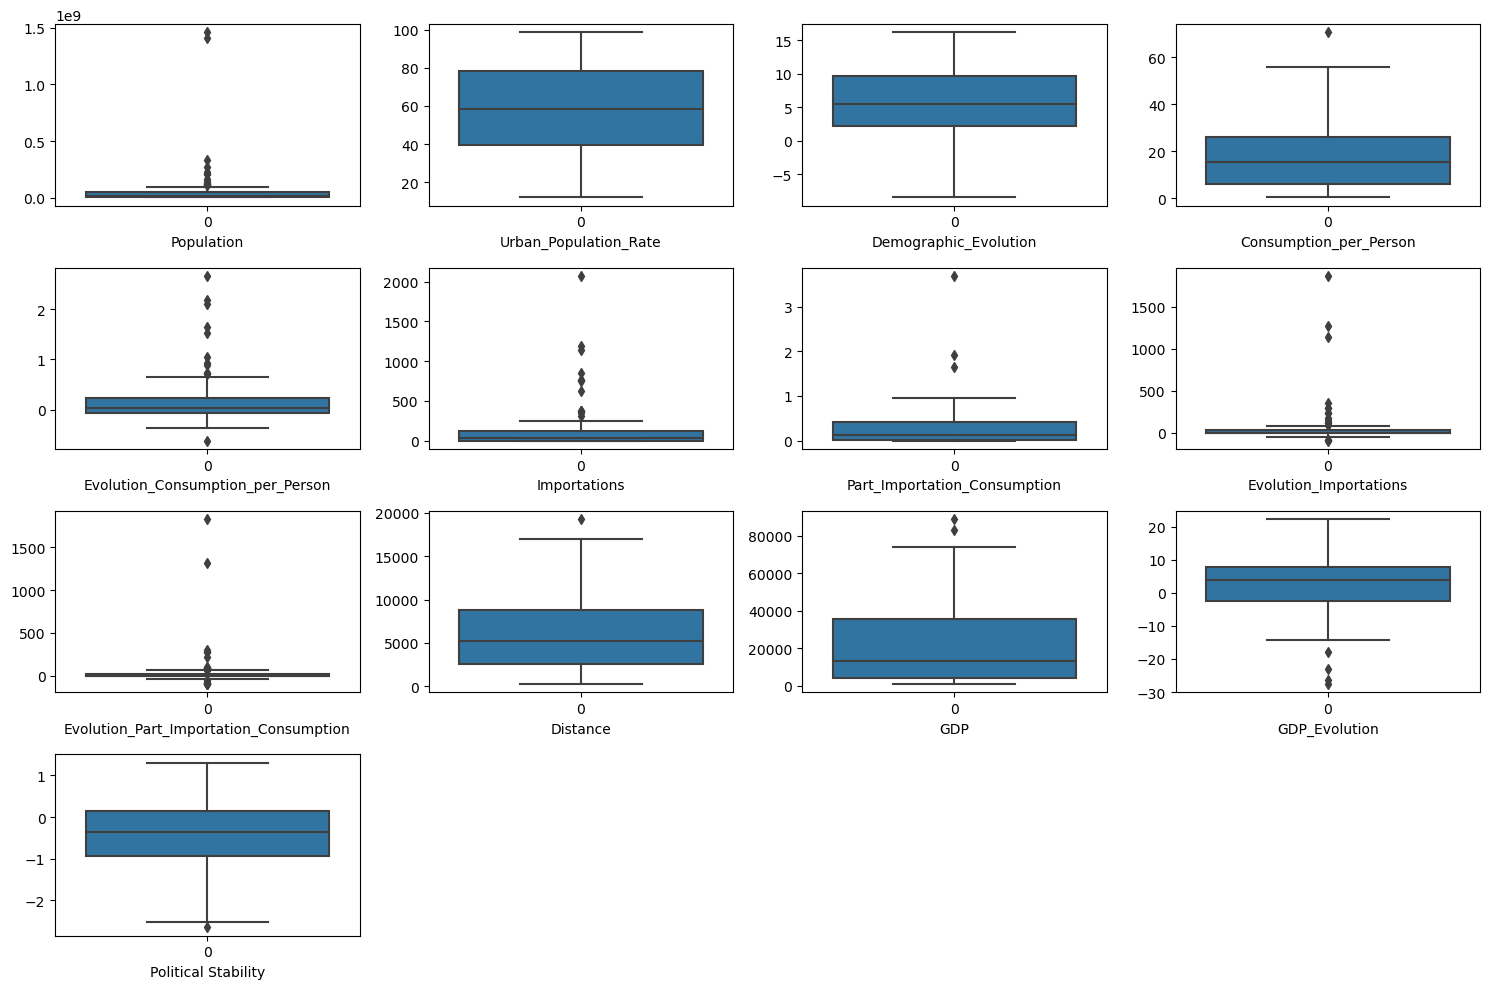

In [89]:
# traitement des valeurs extrèmes
num_cols= analysis_work_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15,10))

for i,col in enumerate (num_cols) :
    plt.subplot(4,len(num_cols)//2-2,i+1)
    sns.boxplot(analysis_work_df[col])
    
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [90]:
# appliquer soit la transformation logaritmique, soit la winsorisation selon le type de variable à traiter

# créer une copie du Df d'origine pour effectuer les transformations
analysis_work_df_transformed = analysis_work_df.copy()

# appliquer la transformation logarithmique aux variables suivantes
log_variables = ['Population', 'Importations', 'GDP', 'Distance']

for var in log_variables:
    # remplacer la colonne dans le DataFrame transformé par la transformation logarithmique
    analysis_work_df_transformed[var] = np.log1p(analysis_work_df_transformed[var])

# appliquer la winsorisation aux variables suivantes
winsorize_variables = ['Evolution_Importations','Part_Importation_Consumption', 'Evolution_Part_Importation_Consumption',
     'Evolution_Consumption_per_Person','GDP_Evolution','Consumption_per_Person']

# winsoriser les 10% des valeurs extrêmes dans le DataFrame transformé
for var in winsorize_variables:
    analysis_work_df_transformed[var] = mstats.winsorize(analysis_work_df_transformed[var], limits=[0.1, 0.1])


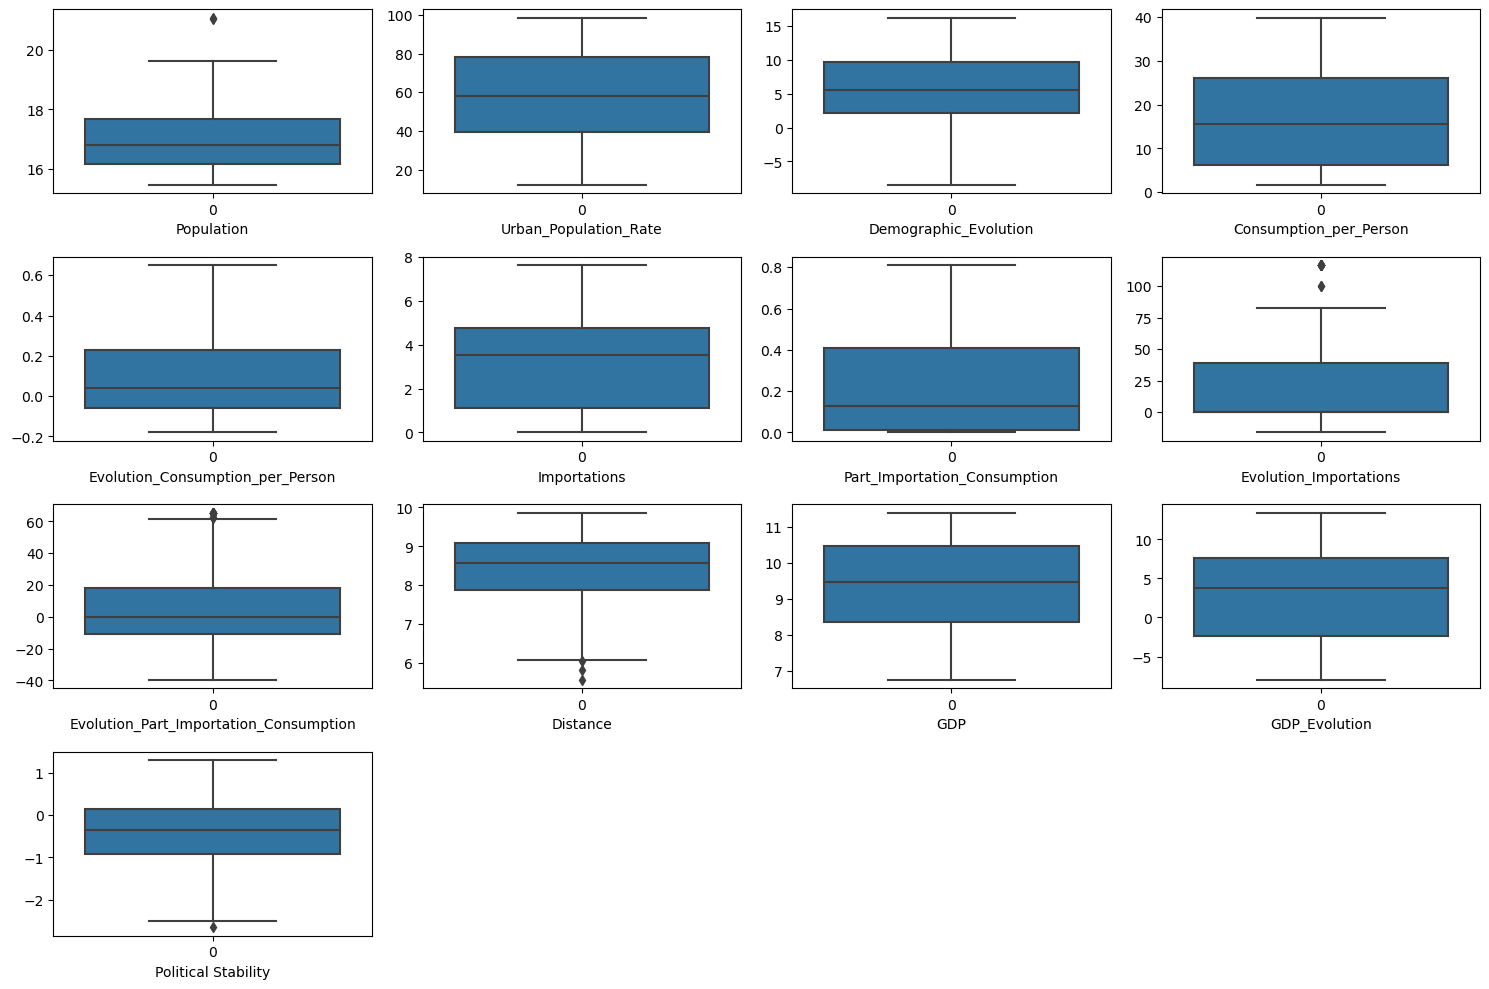

In [91]:
# vérification
num_cols= analysis_work_df_transformed.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15,10))

for i,col in enumerate (num_cols) :
    plt.subplot(4,len(num_cols)//2-2,i+1)
    sns.boxplot(analysis_work_df_transformed[col])
    
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [92]:
analysis_work_df_transformed.head()

,Country,Population,Urban_Population_Rate,Demographic_Evolution,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption,Distance,GDP,GDP_Evolution,Political Stability,Continent
0,Afghanistan,17.506874,25.54,12.50,1.63,-0.15,3.526361,0.54,13.79,19.39,8.628913,7.668514,-7.99,-2.52,Asia
2,Algeria,17.603737,73.91,7.39,6.16,-0.11,0.000000,0.00,0.00,-39.66,7.201171,9.479749,-4.50,-0.74,Africa
5,Angola,17.356579,66.27,14.22,8.72,-0.17,5.509388,0.81,-11.19,-6.18,8.781248,8.910329,-7.99,-0.65,Africa
8,Argentina,17.628305,93.53,2.77,39.89,0.09,2.397895,0.00,25.00,12.04,9.312265,10.208336,-1.26,-0.01,South America
11,Australia,17.070567,85.63,5.41,39.89,-0.05,1.386294,0.00,-15.97,-39.66,9.739556,10.987341,4.08,0.93,Oceania


In [93]:
analysis_work_df_transformed.shape

(113, 15)

In [94]:
analysis_work_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 0 to 232
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 113 non-null    object 
 1   Population                              113 non-null    float64
 2   Urban_Population_Rate                   113 non-null    float64
 3   Demographic_Evolution                   113 non-null    float64
 4   Consumption_per_Person                  113 non-null    float64
 5   Evolution_Consumption_per_Person        113 non-null    float64
 6   Importations                            113 non-null    float64
 7   Part_Importation_Consumption            113 non-null    float64
 8   Evolution_Importations                  113 non-null    float64
 9   Evolution_Part_Importation_Consumption  113 non-null    float64
 10  Distance                                113 non-null    float64
 11

In [95]:
analysis_work_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 0 to 232
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 113 non-null    object 
 1   Population                              113 non-null    float64
 2   Urban_Population_Rate                   113 non-null    float64
 3   Demographic_Evolution                   113 non-null    float64
 4   Consumption_per_Person                  113 non-null    float64
 5   Evolution_Consumption_per_Person        113 non-null    float64
 6   Importations                            113 non-null    float64
 7   Part_Importation_Consumption            113 non-null    float64
 8   Evolution_Importations                  113 non-null    float64
 9   Evolution_Part_Importation_Consumption  113 non-null    float64
 10  Distance                                113 non-null    float64
 11

In [96]:
# vérifier l'abscence de NaN
analysis_work_df_transformed.isna().mean()

Country                                   0.0
Population                                0.0
Urban_Population_Rate                     0.0
Demographic_Evolution                     0.0
Consumption_per_Person                    0.0
Evolution_Consumption_per_Person          0.0
Importations                              0.0
Part_Importation_Consumption              0.0
Evolution_Importations                    0.0
Evolution_Part_Importation_Consumption    0.0
Distance                                  0.0
GDP                                       0.0
GDP_Evolution                             0.0
Political Stability                       0.0
Continent                                 0.0
dtype: float64

In [97]:
analysis_work_df_transformed.describe()

C:\Users\mrgxl\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\mrgxl\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\mrgxl\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\mrgxl\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\mrgxl\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\mrgxl\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArra

,Population,Urban_Population_Rate,Demographic_Evolution,Consumption_per_Person,Evolution_Consumption_per_Person,Importations,Part_Importation_Consumption,Evolution_Importations,Evolution_Part_Importation_Consumption,Distance,GDP,GDP_Evolution,Political Stability
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.00000,113.000000
mean,17.040682,59.023274,5.719912,17.520354,0.117080,3.185487,0.249558,23.145929,5.840000,8.362737,9.372369,3.00000,-0.455575
std,1.177252,22.491469,4.844162,12.846413,0.245915,2.129807,0.282263,41.311311,30.288489,0.882296,1.223550,6.65381,0.945848
min,15.450563,12.070000,-8.460000,1.630000,-0.180000,0.000000,0.000000,-15.970000,-39.660000,5.572154,6.754837,-7.99000,-2.660000
25%,16.145550,39.440000,2.190000,6.200000,-0.060000,1.098612,0.010000,0.000000,-11.070000,7.875119,8.373692,-2.43000,-0.930000
50%,16.805715,58.220000,5.480000,15.480000,0.040000,3.526361,0.130000,0.000000,0.000000,8.566174,9.479749,3.80000,-0.350000
75%,17.675965,78.430000,9.680000,26.140000,0.230000,4.779123,0.410000,39.420000,17.960000,9.078408,10.472482,7.65000,0.140000
max,21.100287,98.600000,16.170000,39.890000,0.650000,7.638198,0.810000,116.670000,65.510000,9.866045,11.393162,13.42000,1.310000


# <a id='section5'></a>5. Analyses univariées et bivariées

## Analyse de la distribution des valeurs

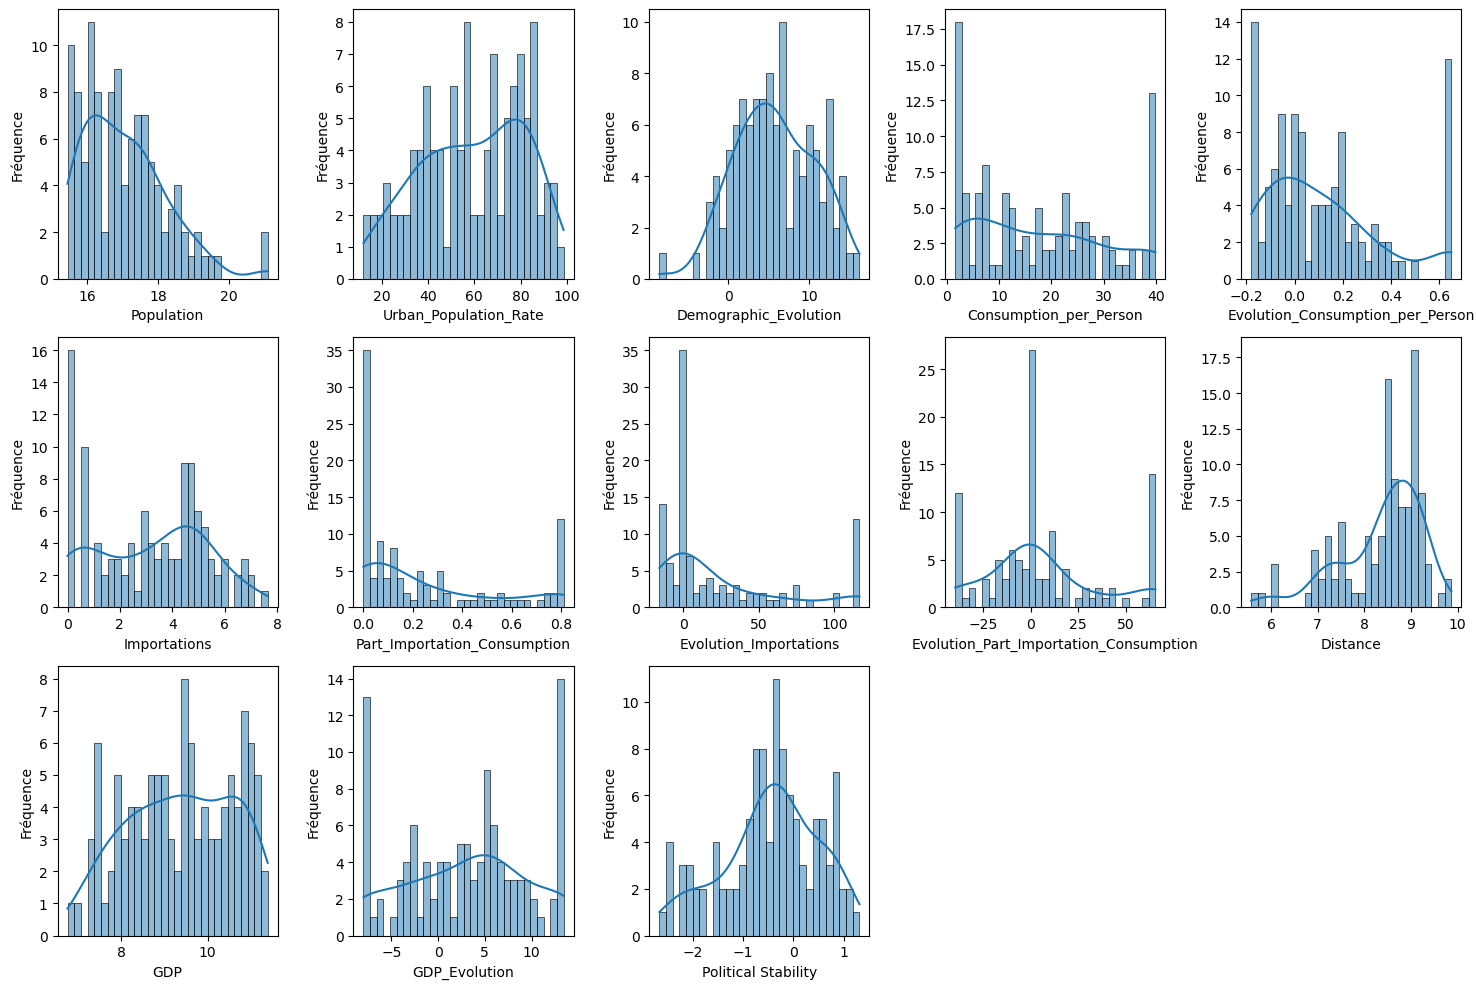

In [98]:
# Afficher les distributions pour chaque variable numérique
num_cols = analysis_work_df_transformed.select_dtypes(include=['float64', 'int64']).columns

# Créer une figure avec des sous-graphiques
plt.figure(figsize=(15, 10))

for i, col in enumerate(num_cols):
    plt.subplot(3, len(num_cols)//3 + 1, i + 1) 
    sns.histplot(analysis_work_df_transformed[col], kde=True, bins=30) 
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

## Analyse des corrélations

In [99]:
# Filtrer les colonnes numériques
numeric_df = analysis_work_df_transformed.select_dtypes(include='number')

In [100]:
# Calculer la matrice de corrélation
correlation_matrix = numeric_df.corr()

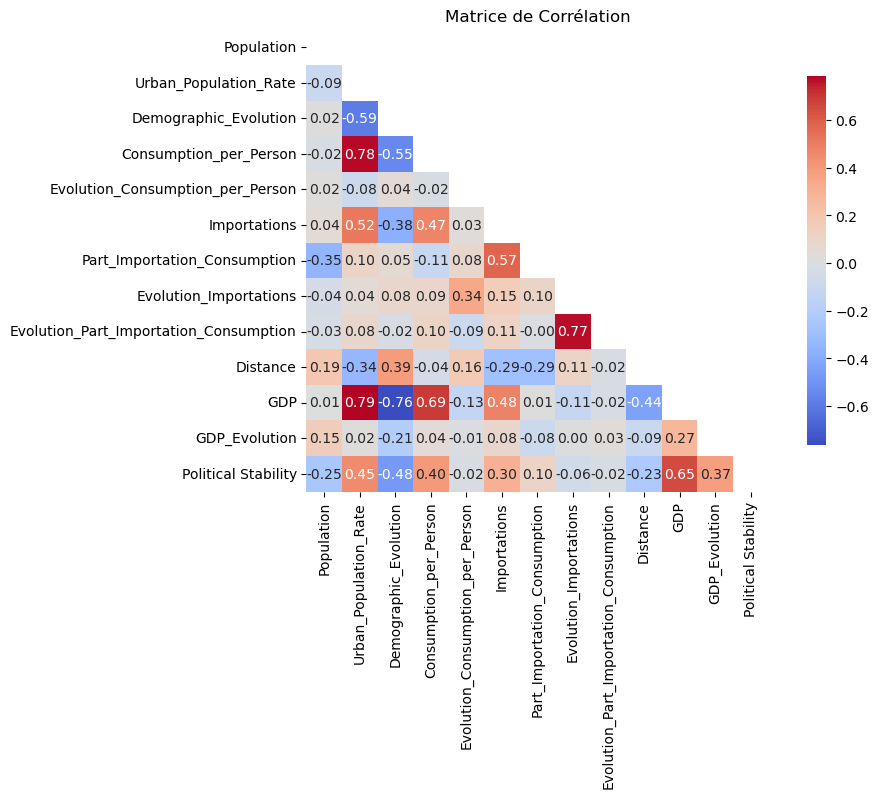

In [101]:
# Afficher la matrice de corrélation avec un heatmap

# Création d'un masque pour n'afficher que la demi-heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 6))

sns.heatmap(correlation_matrix,mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Matrice de Corrélation')

# Sauvegarde du graphique
plt.savefig('Matrice de Corrélation.png')

plt.show()

C:\Users\mrgxl\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\mrgxl\AppData\Local\Temp\ipykernel_15332\1373866293.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


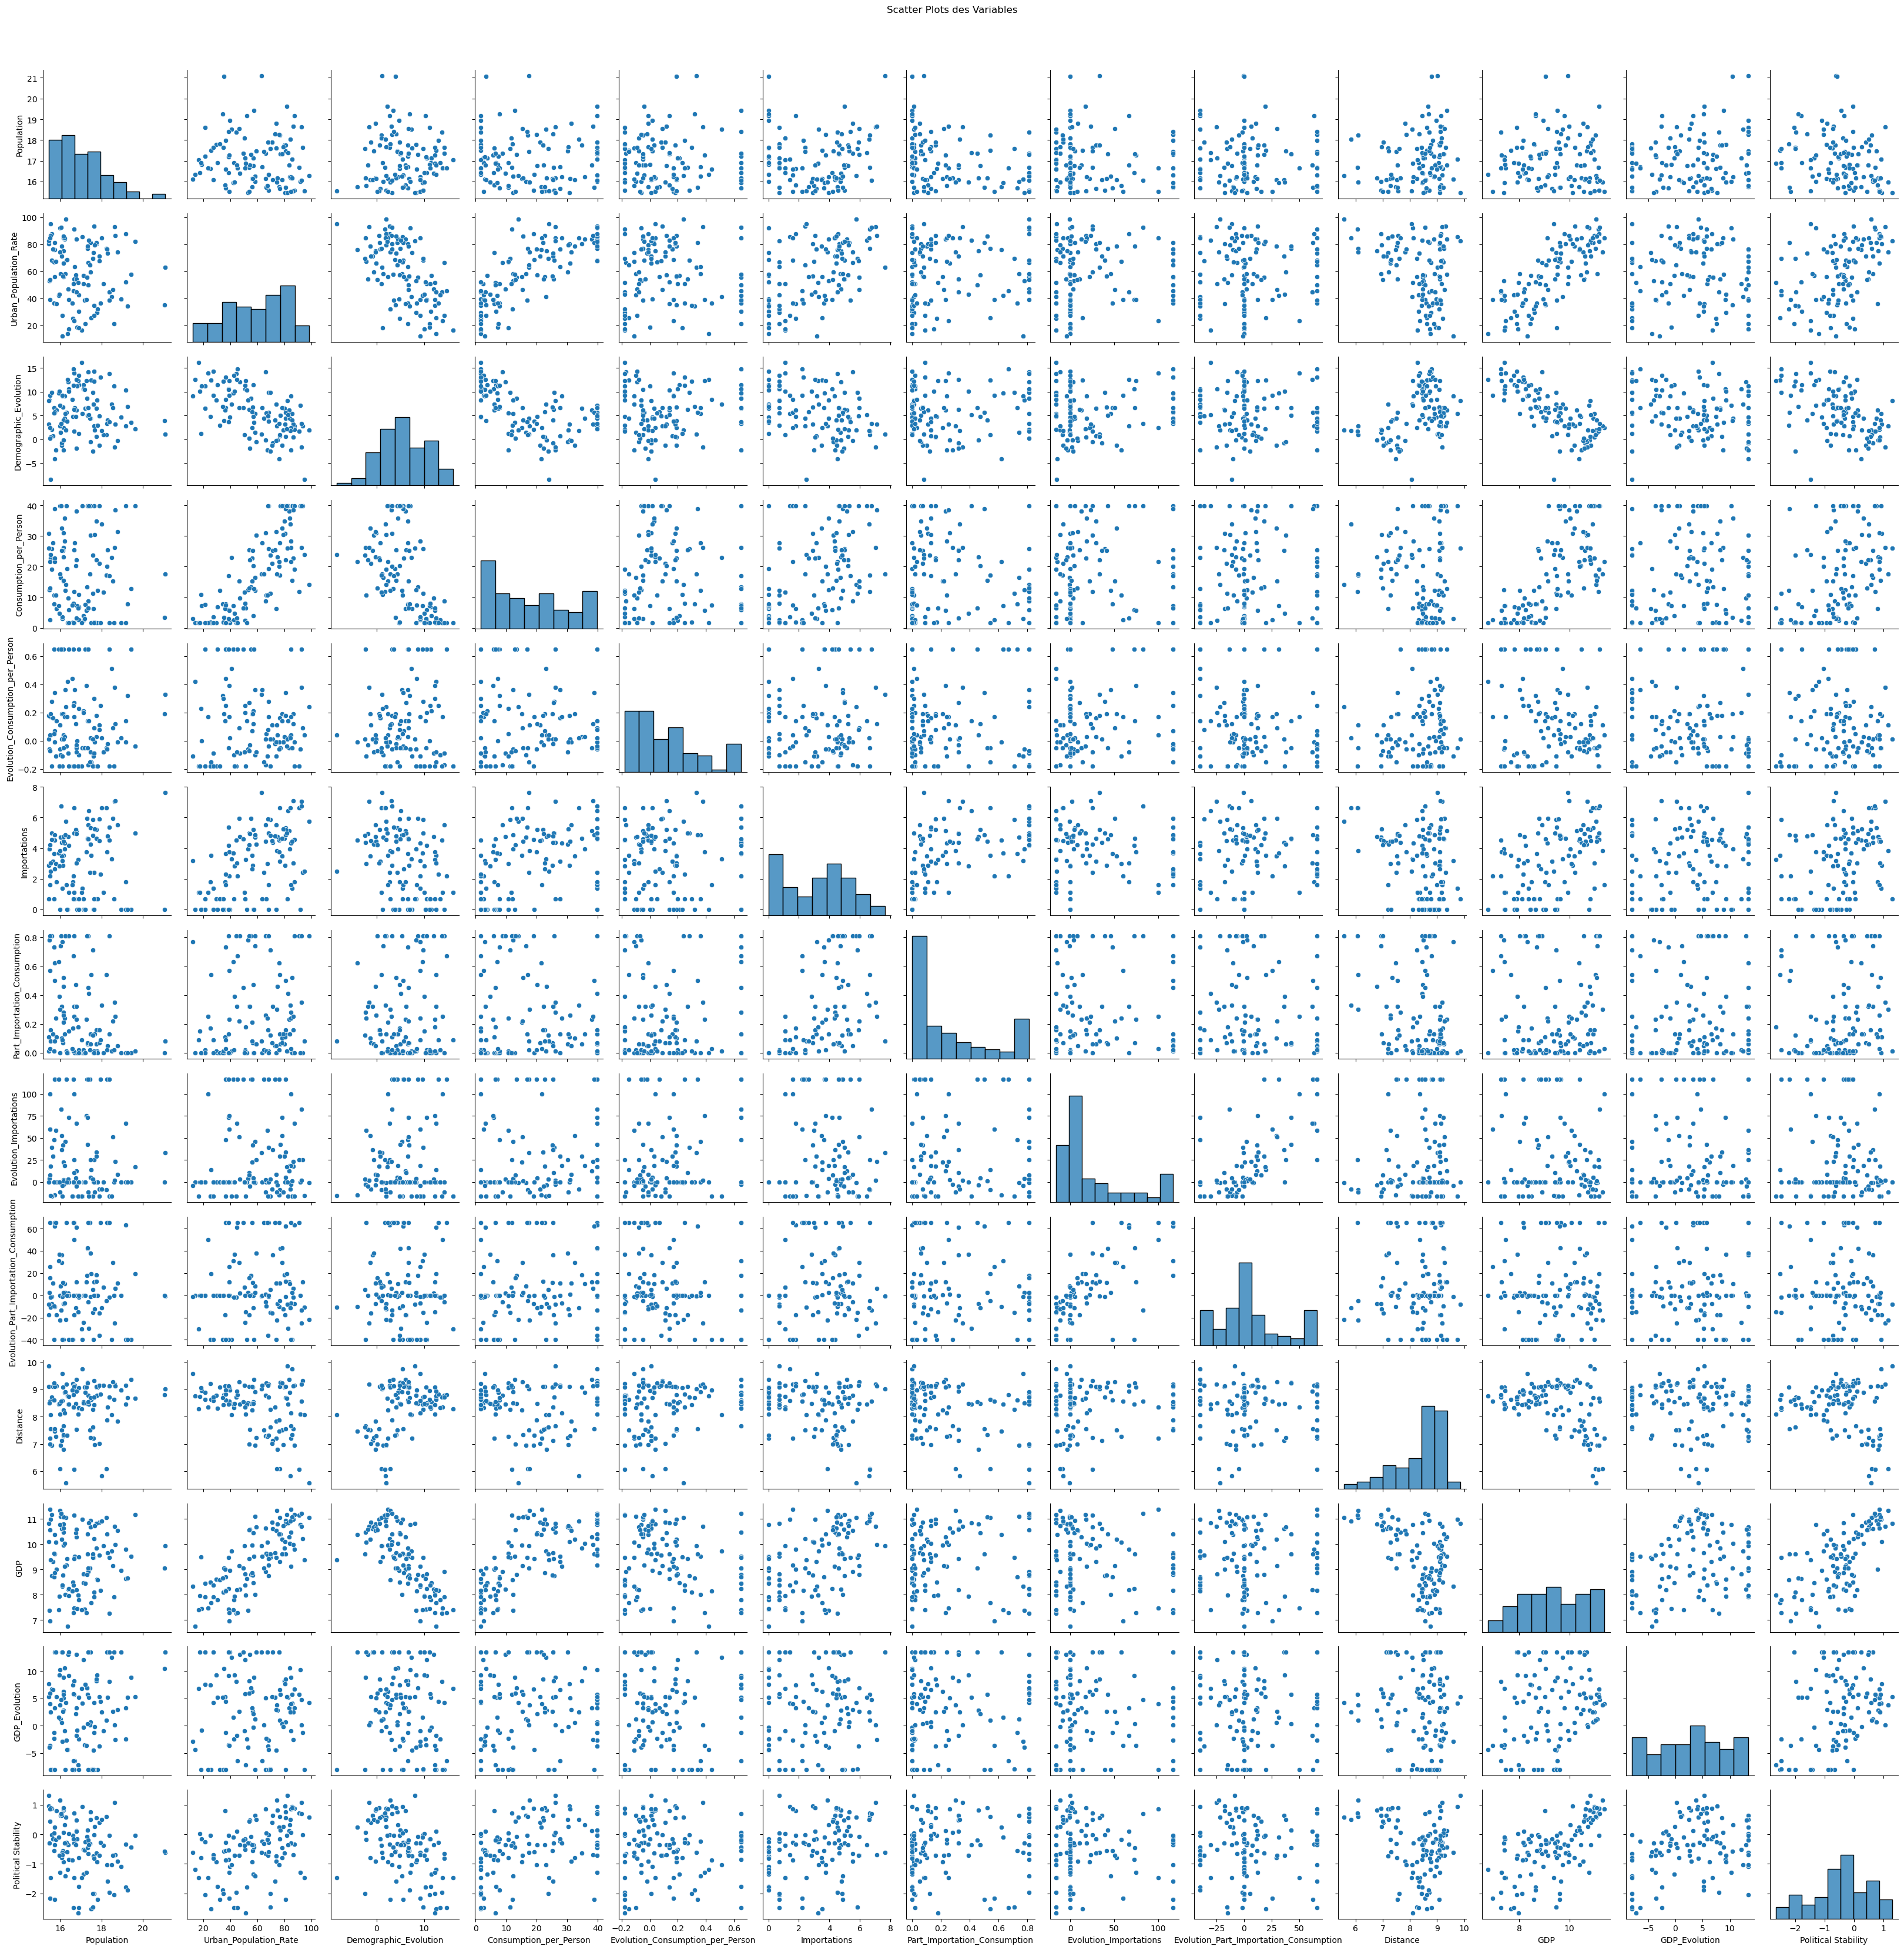

In [102]:
# Créer un pairplot
pair_plot = sns.pairplot(numeric_df, height=2.5)
plt.suptitle('Scatter Plots des Variables', y=1.02) 
plt.tight_layout() 
plt.show()

In [103]:
# Filtrer les paires de variables avec une forte corrélation
strong_correlations = correlation_matrix[correlation_matrix.abs() > 0.5].stack().reset_index()
strong_correlations.columns = ['Variable 1', 'Variable 2', 'Correlation']
# Exclure les paires où Variable 1 et Variable 2 sont les mêmes
strong_correlations = strong_correlations[strong_correlations['Variable 1'] != strong_correlations['Variable 2']]

# Créer une colonne pour les paires triées
strong_correlations['Pair'] = strong_correlations.apply(lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1)

# Supprimer les doublons basés sur la colonne 'Pair'
strong_correlations_unique = strong_correlations.drop_duplicates(subset='Pair')

# Supprimer la colonne 'Pair' si elle n'est plus nécessaire
strong_correlations_unique = strong_correlations_unique.drop(columns='Pair')
strong_correlations_unique

,Variable 1,Variable 2,Correlation
2,Urban_Population_Rate,Demographic_Evolution,-0.591432
3,Urban_Population_Rate,Consumption_per_Person,0.775456
4,Urban_Population_Rate,Importations,0.517225
5,Urban_Population_Rate,GDP,0.785526
8,Demographic_Evolution,Consumption_per_Person,-0.545632
9,Demographic_Evolution,GDP,-0.764288
13,Consumption_per_Person,GDP,0.694584
17,Importations,Part_Importation_Consumption,0.574541
21,Evolution_Importations,Evolution_Part_Importation_Consumption,0.771717
29,GDP,Political Stability,0.651515


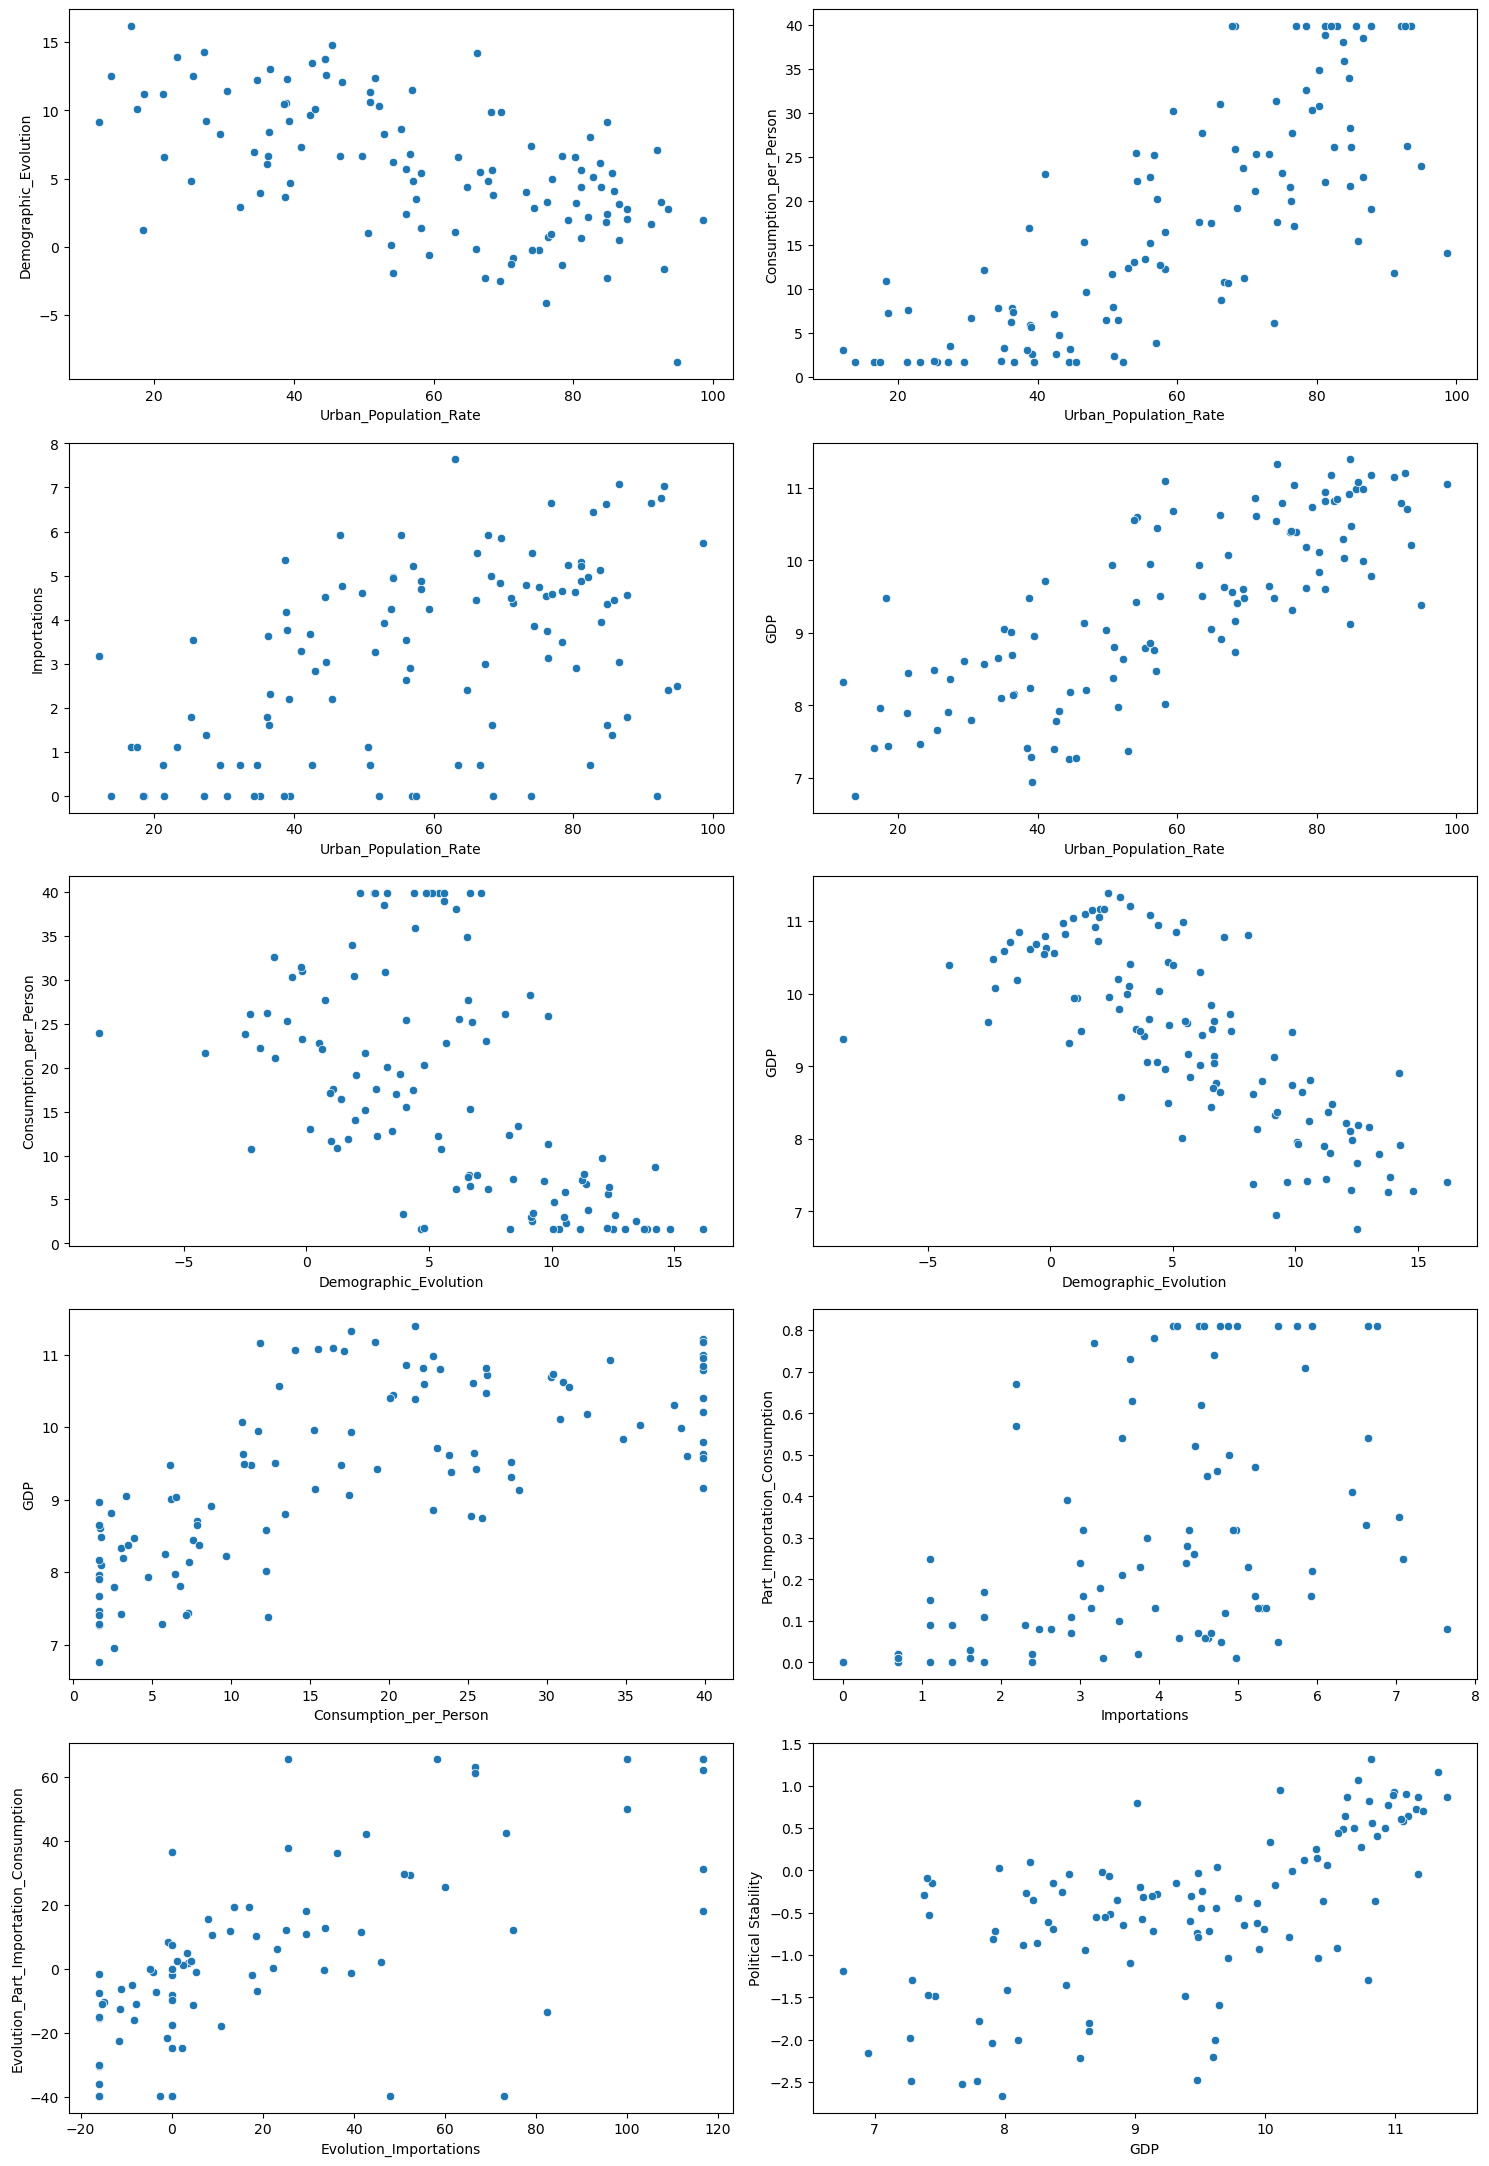

In [104]:
# afficher les scatterplot
plt.figure(figsize=(15, 30))  

# itérer à travers les paires de variables pour créer chaque scatter plot
for i, (var1, var2) in enumerate(zip(strong_correlations_unique['Variable 1'], strong_correlations_unique['Variable 2'])):
    plt.subplot(7, 2, i + 1)
    sns.scatterplot(data=analysis_work_df_transformed, x=var1, y=var2) 
    
plt.tight_layout() 
plt.show()  


## Premières analyses

**Urban Population Rate vs Demographic Evolution :** Il semble y avoir une corrélation négative entre ces deux variables. Cela peut indiquer que dans les pays où le taux d'urbanisation est plus élevé, l'évolution démographique pourrait être plus faible.

**Urban Population Rate vs Consumption per Person :** Cette relation semble indiquer une légère corrélation positive. Un taux plus élevé d'urbanisation pourrait être lié à une consommation moyenne par personne plus élevée.

**Urban Population Rate vs GDP :** Une relation positive est visible ici. Les pays avec un taux d'urbanisation plus élevé ont tendance à avoir un GDP plus élevé.

**Consumption per Person vs GDP :** Cette paire montre également une tendance positive claire. Il est logique que des niveaux plus élevés de consommation individuelle soient associés à des GDP plus élevés.

**Political Stability vs GDP :** Il semble qu'il y ait une relation positive. Les pays plus stables politiquement pourraient avoir tendance à avoir un GDP plus élevé, ce qui n'est pas surprenant.

# <a id='section6'></a>6. Exportations des Data Frame

In [105]:
# Exporter le dataframe en CSV dans le répertoire actuel
analysis_work_df_transformed.to_csv('analysis_work_df_transformed.csv', index=False)
analysis_work_df.to_csv('analysis_work_df.csv', index=False)
cost_to_export_transformed.to_csv('cost_to_export_transformed.csv', index=False)